# Hypothesis Testing Project

# Introduction

## The Project

This project uses the Northwind database--a free, open-source dataset created by Microsoft containing data from a fictional company.

The goal of this project is to gather information from a real-world database and use your knowledge of statistical analysis and hypothesis testing to generate analytical insights that can be of value to the company.

### The Deliverables

The goal of this project is to query the database to get the data needed to perform a statistical analysis.  In this statistical analysis, you'll need to perform a hypothesis test (or perhaps several) to answer the following question:

**_Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?_**

In addition to answering this question with a hypothesis test, you will also need to come up with **_at least 3 other hypotheses to test on your own_**.  These can by anything that you think could be important information for the company.

For this hypothesis, be sure to specify both the **_null hypothesis_** and the **_alternative hypothesis_** for your question.  You should also specify if this is one-tail or a two-tail test.


## Methodology


In this project I will use the Scientific Method. The step are as follows:

### 1. Make an Observation

The first step of the scientific method is to observe something that I want to test. This step involves exploring the data and looking for something that is worth testing. 

### 2. Examine the Research

This means identifying any research that already exists which may help answer my question, directly or indirectly. For the purposes of this project, my research will be limited to investigating the 

### 3. Form a Hypothesis

In this stage, I will formulate two hypotheses to test--your educated guess about the outcome  called the **_Alternative Hypothesis_**, while the opposite of it is called the **_Null Hypothesis_**.   

### 4. Conduct an Experiment

This step involves testing the hypothesis by gathering data from a well-structured experiment.  The experiment is structured to account for any mistakes and randomness that could lead to false signals. 

### 5. Analyze Experimental Results

Here I will determine whether something that happened is **_statistically significant_** or not. 

### 6. Draw Conclusions

In this final stage I will evaluate whether you believe the hypothesis was correct or not! THe analysis of the data will lead to one of two things: either **_reject the null hypothesis or fail to reject the null hypothesis_**.  

source: Flatiron School

<img src='./images/new_the-scientific-method.png' height="75%" width="75%">

# Getting the Data

The database contains sales data for the Northwind company. Northwind sells various food and beverage items, to customers in Europe and the Americas. The database is mapped out below in the Entity Relationship Diagram (ERD)

<img src='./images/Northwind_ERD_updated.png' height="100%" width="100%">

Inspecting the ERD gives me several leads of where to begin my investigation. Although this is a sample database it covers 3 key areas of a business: Products, Customers, and Employees. Even in these segments there are far questions than I can address in the project.

#### 1. Discounts
Do discounts have a statistically significant effect on the quantity of a product in an order?

#### 2. Product Portfolio
What are the drivers of Northwind's business. Is there any difference between product categories?

#### 3. Customers
Who are Northwind's customers? Is there a significant difference between regions?

#### 4. Employees
Who are Northwind's star sales performers? Does any sales center outperform?


## Loading the Data

First step is to load all the required libraries

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import scipy.stats as stat
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Connect to the database

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

Run a query to check the table names. They may differ from the ERD.

In [3]:
cur.execute("SELECT name FROM sqlite_master WHERE type = 'table';")
print(cur.fetchall())

[('Employee',), ('Category',), ('Customer',), ('Shipper',), ('Supplier',), ('Order',), ('Product',), ('OrderDetail',), ('CustomerCustomerDemo',), ('CustomerDemographic',), ('Region',), ('Territory',), ('EmployeeTerritory',)]


# Hypothesis #1: Discounts

## $H_{0}$ Null Hypothesis
**Discounts have no effect on sales order quantity.**

## $H_{1}$ Alternative Hypothesis
**Discounts lead to an increase in sales order quantity**

## Observation and Research

Run a SQL query to select all data from the order details column. I am also adding some additional calculated columns for List Revenue (revenue before discount), Gross Revenue (after discount) Discount Value in $, and a boolean value for whether the line of the order has a discount or not.

In [4]:
cur.execute("""SELECT *,
                od.UnitPrice * od.Quantity AS 'ListRev',
                od.UnitPrice * (1 - od.Discount) * od.Quantity AS 'GrossRev',
                od.Discount * od.UnitPrice * od.Quantity AS 'DiscVal',
                    CASE 
                    WHEN od.Discount == 0 THEN 0
                    ELSE 1 
                    END AS 'Disc_0_1'
                FROM [OrderDetail] od;""")
ord_det = pd.DataFrame(cur.fetchall())
ord_det.columns = [i[0] for i in cur.description]
ord_det.head(5)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,ListRev,GrossRev,DiscVal,Disc_0_1
0,10248/11,10248,11,14.0,12,0.0,168.0,168.0,0.0,0
1,10248/42,10248,42,9.8,10,0.0,98.0,98.0,0.0,0
2,10248/72,10248,72,34.8,5,0.0,174.0,174.0,0.0,0
3,10249/14,10249,14,18.6,9,0.0,167.4,167.4,0.0,0
4,10249/51,10249,51,42.4,40,0.0,1696.0,1696.0,0.0,0


Inspect the distribution of discount levels visually, with a histogram. The majority of order lines have no discount. Discounts are fairly evenly spread, in 5% increments

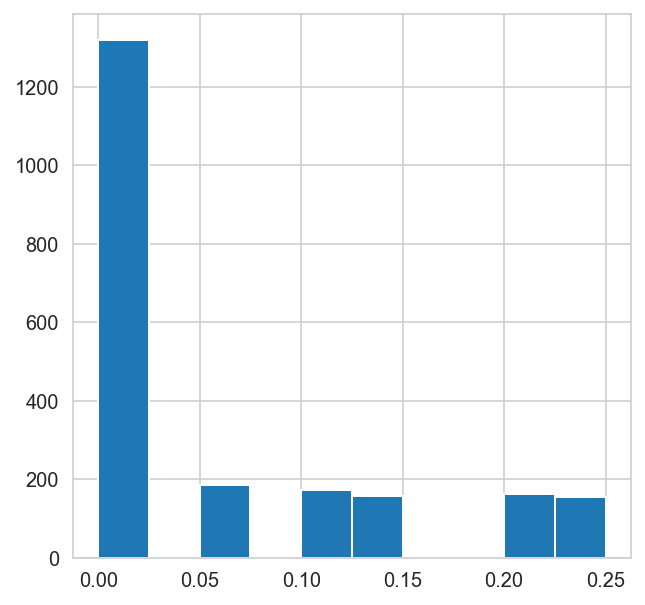

In [5]:
ord_det.Discount.hist(figsize = (5,5));

Since there are not that many levels of discount, I also inspect the count of each discount as a table.

In [6]:
ord_det['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

Confirming the histogram that more than half have no discount, and discounts are evenly split at 5, 10, 15, 20, 25. 
There are some small discount levels with very quantities that don't show up on the histogram

Further investigating the smallest distribution of discounts
Filter on the discount level: 1%, 2%, 3%, 4%, 6%

In [7]:
ord_det.loc[(ord_det['Discount'] <= 0.06) & (ord_det['Discount'] != 0.05) & (ord_det['Discount'] != 0.00)]

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,ListRev,GrossRev,DiscVal,Disc_0_1
2133,11077/6,11077,6,25.00,1,0.02,25.00,24.5000,0.5000,1
2139,11077/14,11077,14,23.25,1,0.03,23.25,22.5525,0.6975,1
2140,11077/16,11077,16,17.45,2,0.03,34.90,33.8530,1.0470,1
2141,11077/20,11077,20,81.00,1,0.04,81.00,77.7600,3.2400,1
2146,11077/46,11077,46,12.00,3,0.02,36.00,35.2800,0.7200,1
2149,11077/60,11077,60,34.00,2,0.06,68.00,63.9200,4.0800,1
2150,11077/64,11077,64,33.25,2,0.03,66.50,64.5050,1.9950,1
2152,11077/73,11077,73,15.00,2,0.01,30.00,29.7000,0.3000,1


That's strange they all have the same order number. Let's look at the total order to see if that gives us any clues

In [8]:
ord_11077 = ord_det[(ord_det['OrderId'] == 11077)]
ord_11077.sort_values(by=['Discount', 'Quantity'], ascending=False)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,ListRev,GrossRev,DiscVal,Disc_0_1
2130,11077/2,11077,2,19.00,24,0.20,456.00,364.8000,91.2000,1
2135,11077/8,11077,8,40.00,2,0.10,80.00,72.0000,8.0000,1
2149,11077/60,11077,60,34.00,2,0.06,68.00,63.9200,4.0800,1
2137,11077/12,11077,12,38.00,2,0.05,76.00,72.2000,3.8000,1
2144,11077/39,11077,39,18.00,2,0.05,36.00,34.2000,1.8000,1
2134,11077/7,11077,7,30.00,1,0.05,30.00,28.5000,1.5000,1
2141,11077/20,11077,20,81.00,1,0.04,81.00,77.7600,3.2400,1
2140,11077/16,11077,16,17.45,2,0.03,34.90,33.8530,1.0470,1
2150,11077/64,11077,64,33.25,2,0.03,66.50,64.5050,1.9950,1
2139,11077/14,11077,14,23.25,1,0.03,23.25,22.5525,0.6975,1


Nothing in this order jumps out as unusual, how about by product and Category?

In [9]:
cur.execute("""SELECT OrderId, ProductId, od.UnitPrice, Quantity, Discount,
                ProductName, CategoryId,
                CategoryName
                FROM [OrderDetail] od
                JOIN [Product] p
                ON od.ProductId = p.Id
                JOIN Category c
                ON c.Id = p.CategoryId
                WHERE OrderId == '11077' 
                AND Discount >= '0.01' AND Discount <= '0.06' AND Discount != '0.05' """);
                      
what_prod_df = pd.DataFrame(cur.fetchall())
what_prod_df.columns = [i[0] for i in cur.description]
what_prod_df.sort_values(by=['CategoryName'])

,OrderId,ProductId,UnitPrice,Quantity,Discount,ProductName,CategoryId,CategoryName
0,11077,6,25.00,1,0.02,Grandma's Boysenberry Spread,2,Condiments
2,11077,16,17.45,2,0.03,Pavlova,3,Confections
3,11077,20,81.00,1,0.04,Sir Rodney's Marmalade,3,Confections
5,11077,60,34.00,2,0.06,Camembert Pierrot,4,Dairy Products
6,11077,64,33.25,2,0.03,Wimmers gute Semmelknödel,5,Grains/Cereals
1,11077,14,23.25,1,0.03,Tofu,7,Produce
4,11077,46,12.00,3,0.02,Spegesild,8,Seafood
7,11077,73,15.00,2,0.01,Röd Kaviar,8,Seafood


The order covers multiple catageories and has different discounts within each. 
Let's see who placed the order, and we'll follow up with a question to them.

In [10]:
cur.execute("""SELECT DISTINCT OrderId,
                FirstName, LastName, Title, City, Country
                FROM [OrderDetail] od
                LEFT JOIN [Order] o
                ON od.OrderId = o.Id
                LEFT JOIN Employee e
                ON o.EmployeeId = e.Id
                WHERE OrderId == '11077' """);
                      
Who_df = pd.DataFrame(cur.fetchall())
Who_df.columns = [i[0] for i in cur.description]
Who_df

,OrderId,FirstName,LastName,Title,City,Country
0,11077,Nancy,Davolio,Sales Representative,Seattle,USA


Although this is outside of my research. I do have a follow up question for Nancy Davolio. **Why does this order have unusual discounts?**

As there are not a lot of these 'rogue' discounts. I'm going to include them with the lowest discount level of 5%. 
Query the database and create a new column that groups the discounts in 5% increments. (Only changing 1,2,3,4,6%)

In [11]:
cur.execute("""SELECT *,
                od.UnitPrice * od.Quantity AS 'ListRev',
                od.UnitPrice * (1 - od.Discount) * od.Quantity AS 'GrossRev',
                od.Discount * od.UnitPrice * od.Quantity AS 'DiscVal',
                    CASE 
                    WHEN od.Discount == 0 THEN 0
                    ELSE 1 
                    END AS 'Disc_0_1',
                    CASE
                    WHEN od.Discount BETWEEN 0.01 AND 0.06 THEN 0.05
                    ELSE od.Discount
                    END AS 'Disc_Group'
                FROM [OrderDetail] od;""")
ord_det = pd.DataFrame(cur.fetchall())
ord_det.columns = [i[0] for i in cur.description]
ord_det.head(8)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,ListRev,GrossRev,DiscVal,Disc_0_1,Disc_Group
0,10248/11,10248,11,14.0,12,0.00,168.0,168.0,0.0,0,0.00
1,10248/42,10248,42,9.8,10,0.00,98.0,98.0,0.0,0,0.00
2,10248/72,10248,72,34.8,5,0.00,174.0,174.0,0.0,0,0.00
3,10249/14,10249,14,18.6,9,0.00,167.4,167.4,0.0,0,0.00
4,10249/51,10249,51,42.4,40,0.00,1696.0,1696.0,0.0,0,0.00
5,10250/41,10250,41,7.7,10,0.00,77.0,77.0,0.0,0,0.00
6,10250/51,10250,51,42.4,35,0.15,1484.0,1261.4,222.6,1,0.15
7,10250/65,10250,65,16.8,15,0.15,252.0,214.2,37.8,1,0.15


## Pre-test

Separate the data into discounted and non discounted. This makes it easier to perform some tests.

In [12]:
disc = ord_det[ord_det['Discount']>0]
no_disc = ord_det[ord_det['Discount']==0]

In [13]:
disc.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,ListRev,GrossRev,DiscVal,Disc_0_1,Disc_Group
6,10250/51,10250,51,42.4,35,0.15,1484.0,1261.40,222.60,1,0.15
7,10250/65,10250,65,16.8,15,0.15,252.0,214.20,37.80,1,0.15
8,10251/22,10251,22,16.8,6,0.05,100.8,95.76,5.04,1,0.05
9,10251/57,10251,57,15.6,15,0.05,234.0,222.30,11.70,1,0.05
11,10252/20,10252,20,64.8,40,0.05,2592.0,2462.40,129.60,1,0.05


In [14]:
len(ord_det), len(no_disc), len(disc)

(2155, 1317, 838)

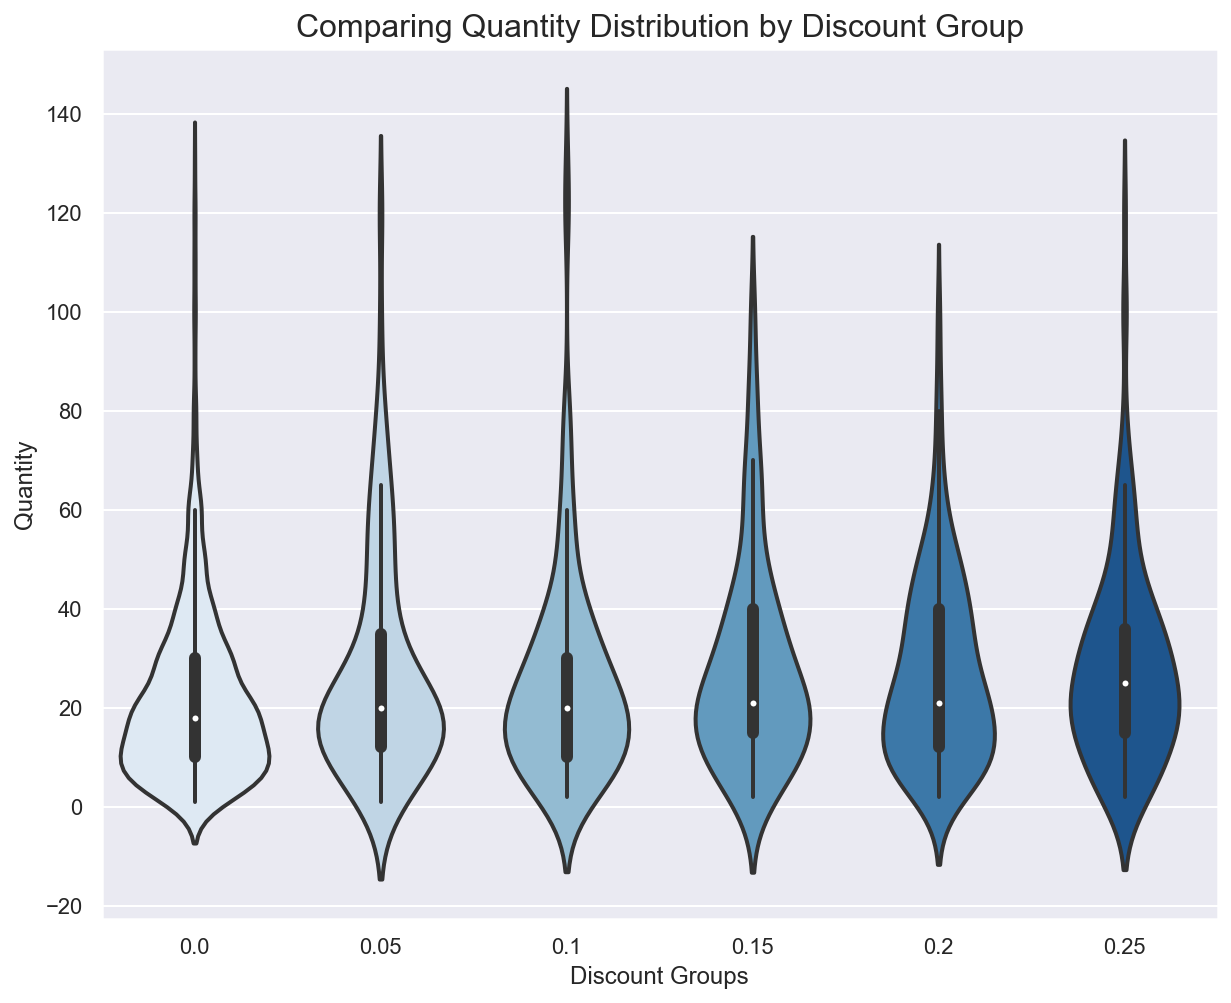

In [15]:
# Violin plot by discount group
sns.set(rc={'figure.figsize':(10,8)})
sns.set(color_codes=True)
sns.violinplot( x=ord_det["Disc_Group"], y=ord_det["Quantity"], linewidth=2, palette="Blues")
plt.xlabel("Discount Groups")
plt.ylabel("Quantity")
plt.title('Comparing Quantity Distribution by Discount Group', fontsize = 16)
plt.show();

**Interpretation**
All the discount groups have a higher mean and interquartile range than the non-discount group. The discount groups have a flatter, more spread distribution than non-discount; especially at 20% and 25% discount. The 10% has a similar mean to 5% and 15%, but the interquartile range appears to be lower and of a smaller range.

In [16]:
disc_summary = ord_det.groupby(ord_det.Disc_Group).agg({'Quantity': ['count', 'sum', 'mean'], 'GrossRev': 'sum', 'UnitPrice': 'mean'})
disc_summary

Quantity                       GrossRev  UnitPrice
              count    sum       mean          sum       mean
Disc_Group                                                   
0.00           1317  28599  21.715262  750698.6100  26.171534
0.05            193   5196  26.922280  147969.4450  30.768238
0.10            173   4366  25.236994   91499.1390  25.171561
0.15            157   4456  28.382166   87506.1740  22.975924
0.20            161   4351  27.024845   89181.1040  23.526770
0.25            154   4349  28.240260   98938.5675  28.214416

Test to see if the distributions are normal

In [17]:
stat.normaltest(disc['Quantity'])

NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57)

In [18]:
stat.normaltest(no_disc['Quantity'])

NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)

The normal test has a null hypothesis that the distribution is normal. However, in our case the p-values are tiny, so we reject the null hypothesis. The most common alpha value is $\alpha = 0.05$. Even with a value much smaller than this we would reject the null hypothesis.

$p < \alpha$: Reject the Null Hypothesis that the distribution is normal.

Let's inspect the two distributions visually

In [19]:
# naming the discount / non discount series for simplicty
Discount_Qty = disc['Quantity']
No_Discount_Qty = no_disc['Quantity']

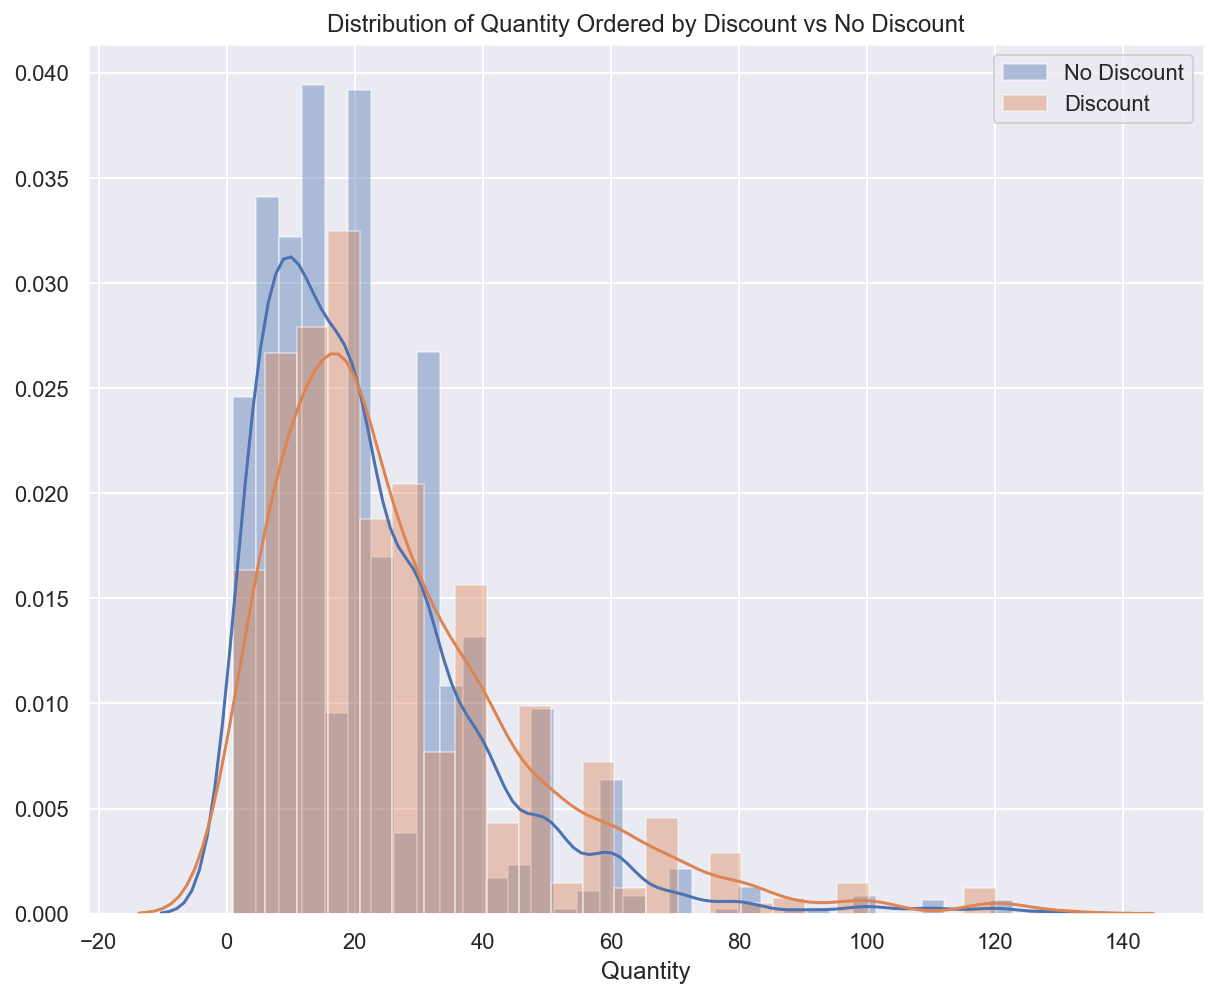

In [20]:
# Plot with overlapping of distribution means and sds

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(10,8)})
sns.distplot(No_Discount_Qty, label='No Discount') # blue dist
sns.distplot(Discount_Qty, label='Discount') # orange dist
plt.title('Distribution of Quantity Ordered by Discount vs No Discount')
plt.legend()
plt.show();

We see a similar distribution shape between discount and no discount. The discount appears to have a higher mean, in that its peak is at a higher quantity.

## Experiment, Testing and Interpret

In the experiment section we will test against our **$H_{0}$ Null Hypothesis** that discounts have no effect on sales order quantity.

We will perform four test in the experiment section. We are performing a one-tail test - as we are interested in whether discounts **increase** order quantity, rather than whether they change (increase or decrease) order quantity.

### 1. Welch's t-test
Used to compare the means of two groups of samples when the variances are different.

### 2. Cohen's d
Used to measure the effect size, or the strength of the relationship between the two samples. It measured the standardize difference between two means.

### 3. ANOVA
ANOVA (Analysis of Variance) is a method for generalizing statistical tests to multiple groups. ANOVA analyses the overall variance of a dataset. It is useful for testing more than two means - all discount groups in our example.

### 4. Tukey Test
Is used after an ANOVA test. While an ANOVA test can tell you whether your results are significant overall, it won’t tell significance within groups. This test compares all possible pairs of means.

### Welch's t-test

In [21]:
Welch_ttest = stat.ttest_ind(No_Discount_Qty, Discount_Qty, equal_var=False)
print(Welch_ttest)
print("This is a 2-tail test. To get the p-value for a one-tail test we divide by 2. \np-value is:", 
      round(Welch_ttest[1]/2,14))

Ttest_indResult(statistic=-6.239069142123973, pvalue=5.65641429030433e-10)
This is a 2-tail test. To get the p-value for a one-tail test we divide by 2. 
p-value is: 2.8282e-10


#### Interpretation
We get a p-value of 2.8282e-10, this is less than our $\alpha = 0.05$

Since $p < \alpha$ we reject the Null Hypothesis that discount has no effect on order quantity. There is statistical evidence at the 5% level of significance that the mean order quantity of discounted orders is greater than the mean order quantity with no discount.


### Cohen's d

In [22]:
# Cohen's d formula

def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled variance
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [23]:
Cohen_d(Discount_Qty, No_Discount_Qty)

0.2862724481729283

#### Interpretation

Cohen provided some general “rule of thumb” guidelines (which should be used cautiously):

Small effect = 0.2
Medium Effect = 0.5
Large Effect = 0.8

Based on these guidelines we can say that discounts have a **small** statistically significant effect on order quantity

### ANOVA

In [24]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [25]:
f1 = 'Disc_Group'
f2 = 'Quantity'

In [26]:
formula = '{} ~ C({})'.format(f2, f1)
lm = ols(formula, ord_det).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq      df         F        PR(>F)
C(Disc_Group)   15969.214452     5.0  8.990431  1.816734e-08
Residual       763430.421743  2149.0       NaN           NaN


#### Interpretation
With ANOVA we are testing whether there is a significant difference between discount groups.
The model gives us a p-value of 1.8167e-08, which is less than our $\alpha = 0.05$. We can reject the Null Hypothesis that there is no difference between groups. We don't know which specific levels of discount are significant, only that in total they are significant.

### Tukey test

In [27]:
mc = MultiComparison(ord_det.Quantity, ord_det.Disc_Group)
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    0.05   5.207    1.0635  9.3506  True 
 0.0    0.1    3.5217  -0.8257  7.8692 False 
 0.0    0.15   6.6669   2.1279 11.2059  True 
 0.0    0.2    5.3096   0.8212  9.7979  True 
 0.0    0.25   6.525    1.9467 11.1033  True 
 0.05   0.1   -1.6853  -7.3138  3.9432 False 
 0.05   0.15   1.4599  -4.3179  7.2377 False 
 0.05   0.2    0.1026  -5.6355  5.8406 False 
 0.05   0.25   1.318   -4.4907  7.1267 False 
 0.1    0.15   3.1452  -2.7805  9.0709 False 
 0.1    0.2    1.7879  -4.0991  7.6748 False 
 0.1    0.25   3.0033  -2.9526  8.9591 False 
 0.15   0.2   -1.3573  -7.3872  4.6725 False 
 0.15   0.25  -0.1419   -6.239  5.9552 False 
 0.2    0.25   1.2154  -4.8441  7.2749 False 
---------------------------------------------
[0.   0.05 0.1  0.15 0.2  0.25]


#### Interpretation
Discount levels of 5%, 15%, 20% and 25% produce a significant difference compared against no discount. However, there is no significant difference between the different levels of discount.

## Conclusion

* There is sufficient evidence to reject the Null Hypothesis that discounts have no effect. Discounts produce a small statistically significant effect on the mean order quantity.
* In particular discount amounts of 5%, 15%, 20% and 25% have a significant effect compared with no discount. There is no significant effect between discounts - a 5% discount appears to have the same effect as a 25% discount.

# Hypothesis #2: Categories

## $H_{0}$ Null Hypothesis
**There is no difference in sales order quantity between product categories.**

## $H_{1}$ Alternative Hypothesis
**There is a difference in sales order quantity between product categories**

Getting data for Categories.
Test - there is no difference in discount level by Category

In [28]:
cur.execute("""SELECT OrderId, ProductId, od.UnitPrice, Quantity, Discount,
                ProductName, CategoryId, CategoryName,
                od.UnitPrice * od.Quantity AS 'ListRev',
                od.UnitPrice * (1 - od.Discount) * od.Quantity AS 'GrossRev',
                od.Discount * od.UnitPrice * od.Quantity AS 'DiscVal',
                    CASE 
                    WHEN od.Discount == 0 THEN 0
                    ELSE 1 
                    END AS 'Disc_0_1'
                FROM [OrderDetail] od
                JOIN [Product] p
                ON od.ProductId = p.Id
                JOIN Category c
                ON c.Id = p.CategoryId""");
                      
Cat_df = pd.DataFrame(cur.fetchall())
Cat_df.columns = [i[0] for i in cur.description]
print(len(Cat_df))
Cat_df.head()

2155


,OrderId,ProductId,UnitPrice,Quantity,Discount,ProductName,CategoryId,CategoryName,ListRev,GrossRev,DiscVal,Disc_0_1
0,10248,11,14.0,12,0.0,Queso Cabrales,4,Dairy Products,168.0,168.0,0.0,0
1,10248,42,9.8,10,0.0,Singaporean Hokkien Fried Mee,5,Grains/Cereals,98.0,98.0,0.0,0
2,10248,72,34.8,5,0.0,Mozzarella di Giovanni,4,Dairy Products,174.0,174.0,0.0,0
3,10249,14,18.6,9,0.0,Tofu,7,Produce,167.4,167.4,0.0,0
4,10249,51,42.4,40,0.0,Manjimup Dried Apples,7,Produce,1696.0,1696.0,0.0,0


Group by Category Name to inspect aggregations

In [29]:
cat_summary = Cat_df.groupby(Cat_df.CategoryName).agg({'Quantity': ['count', 'sum', 'mean'], 'GrossRev': 'sum', 'UnitPrice': 'mean'})
cat_summary

Quantity                      GrossRev  UnitPrice
                  count   sum       mean          sum       mean
CategoryName                                                    
Beverages           404  9532  23.594059  267868.1800  29.236757
Condiments          216  5298  24.527778  106047.0850  21.320833
Confections         334  7906  23.670659  167357.2250  22.602695
Dairy Products      366  9149  24.997268  234507.2850  26.983060
Grains/Cereals      196  4562  23.275510   95744.5875  21.246429
Meat/Poultry        173  4199  24.271676  163022.3595  42.874740
Produce             136  2990  21.985294   99984.5800  35.194485
Seafood             330  7681  23.275758  131261.7375  19.062970

View Category by Total Order Quantity

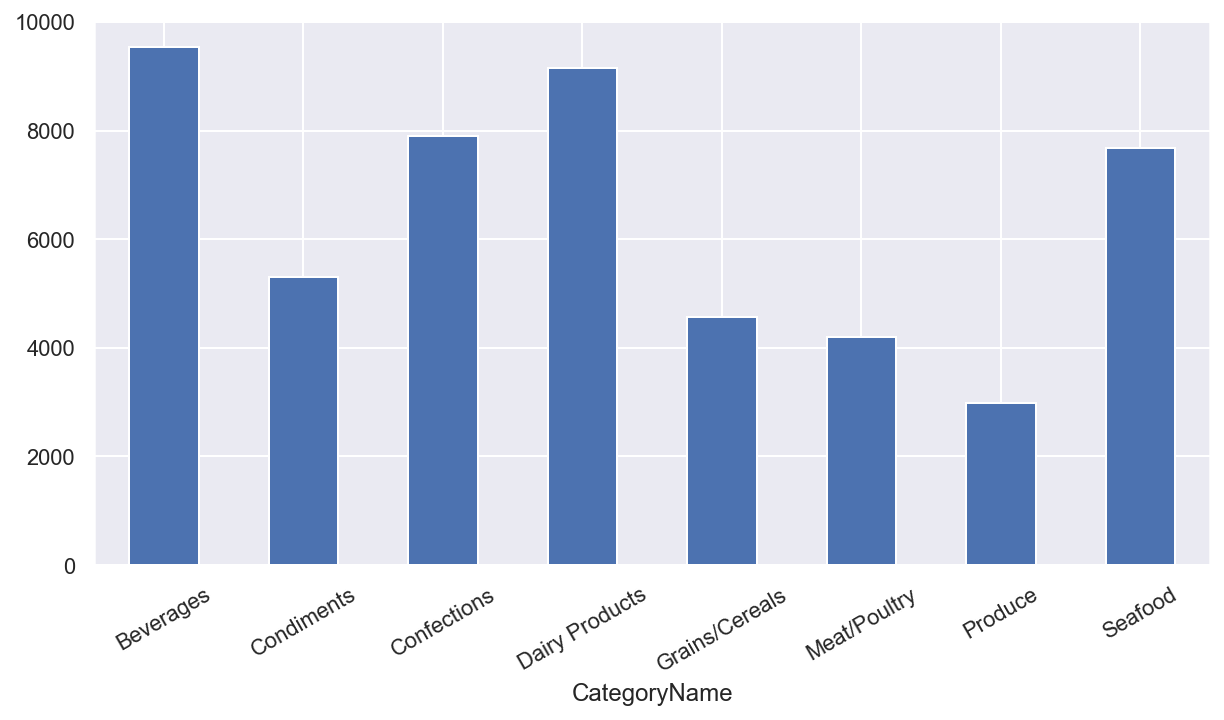

In [30]:
plt.figure(figsize=(10,5))
sum = Cat_df.groupby('CategoryName')['Quantity'].sum()
sum.plot.bar(x='CategoryName', y='Quantity')
plt.xticks(rotation=30)
plt.show();

View Category by Total Gross Revenue. This is similar to quantity, but Seafood is relatively lower, and Meat realtively higher - indicating a differences in unit prices

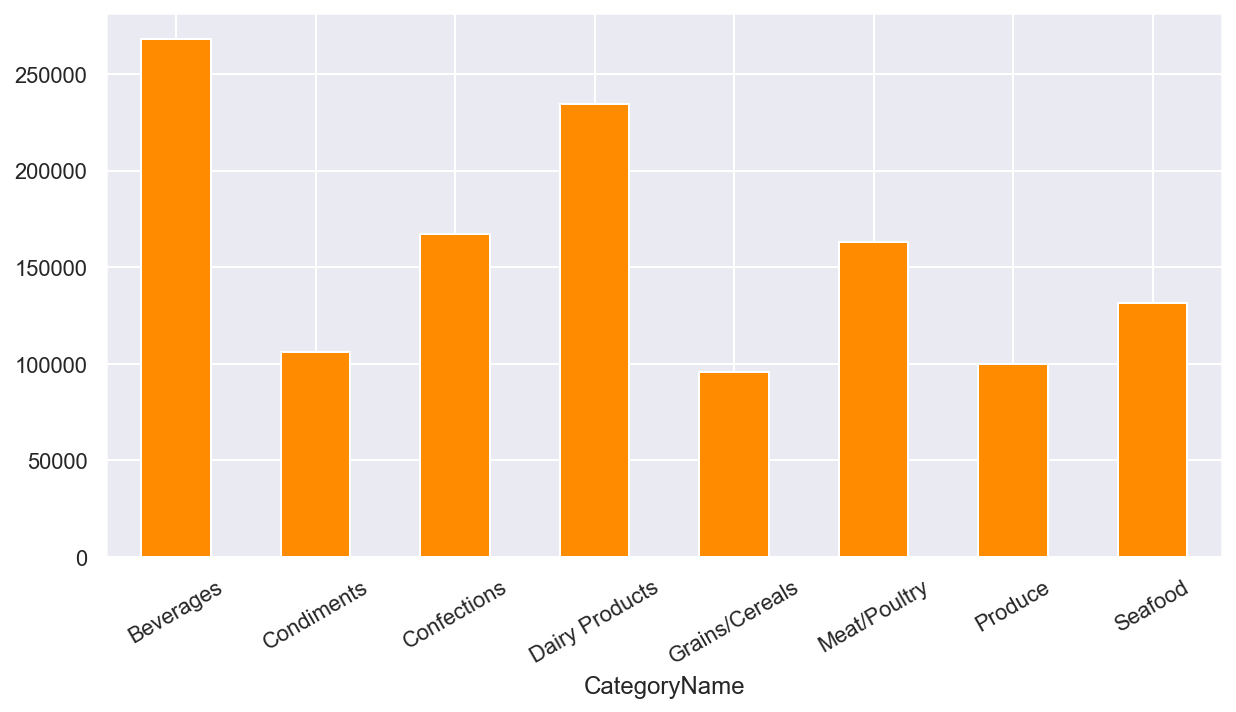

In [31]:
plt.figure(figsize=(10,5))
sum = Cat_df.groupby('CategoryName')['GrossRev'].sum()
sum.plot.bar(x='CategoryName', y='GrossRev', color='darkorange')
plt.xticks(rotation=30)
plt.show();

Category by mean order quantity

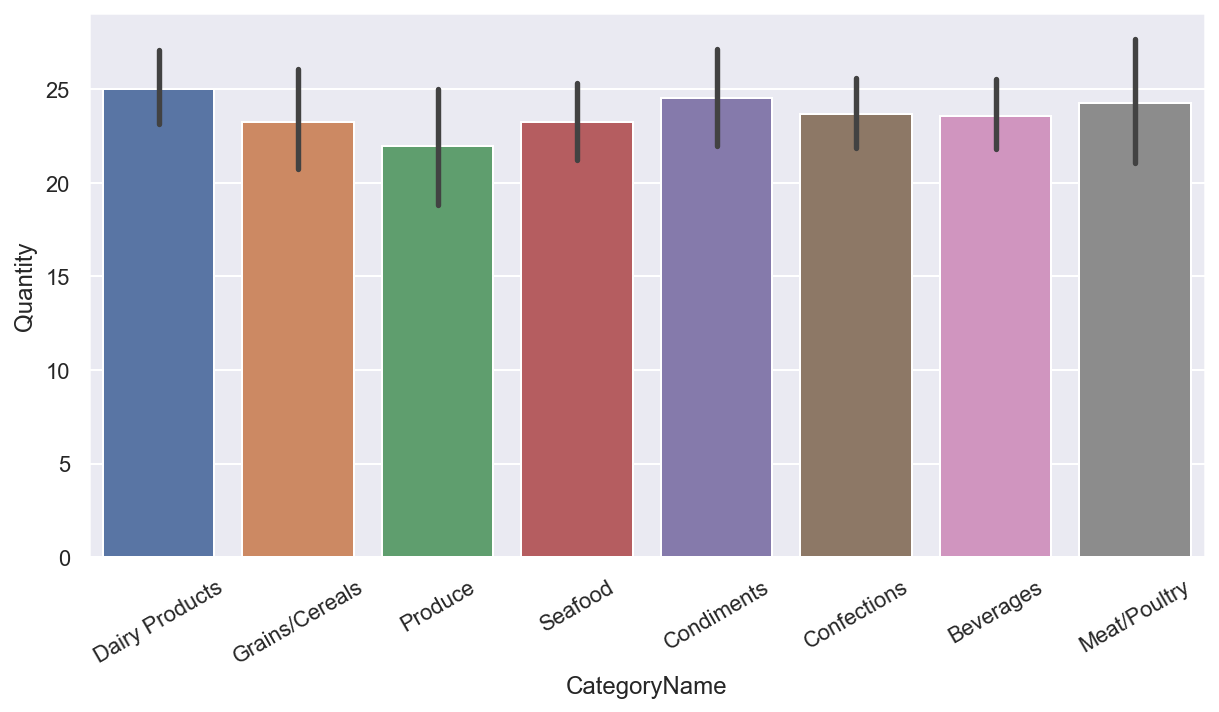

In [32]:
plt.figure(figsize=(10,5))
sns.barplot(x='CategoryName', y='Quantity', data=Cat_df)
plt.xticks(rotation=30)
plt.show();

Category by mean order revenue

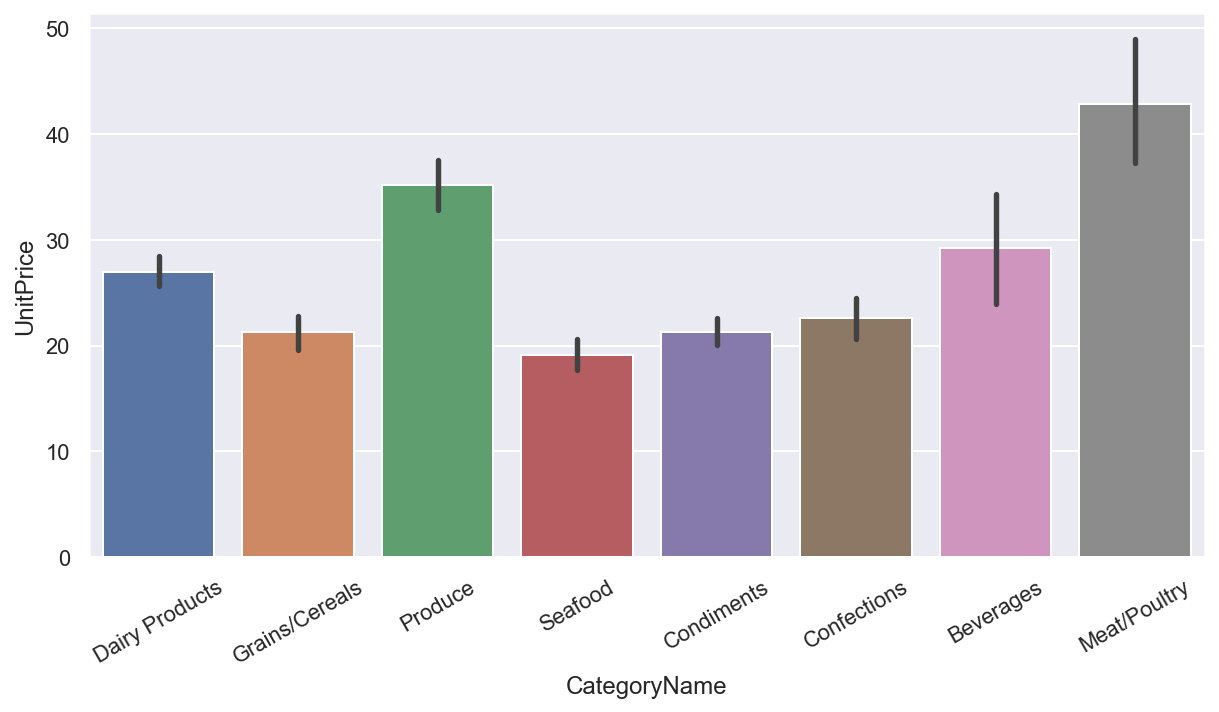

In [33]:
plt.figure(figsize=(10,5))
sns.barplot(x='CategoryName', y='UnitPrice', data=Cat_df)
plt.xticks(rotation=30)
plt.show();

## Experiment, Testing and Interpret

In the experiment section we will test against our **$H_{0}$ Null Hypothesis** that product Categories have no effect on sales order quantity.

For this experiment we are testing multiple groups. So we will only perform ANOVA and Tukey Test.

### ANOVA

In [34]:
f1 = 'CategoryName'
f2 = 'Quantity'

In [35]:
formula = '{} ~ C({})'.format(f2, f1)
lm = ols(formula, Cat_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                        sum_sq      df         F    PR(>F)
C(CategoryName)    1292.377084     7.0  0.509429  0.828058
Residual         778107.259110  2147.0       NaN       NaN


#### Interpretation
The model gives us a p-value of 0.8281, which is greater than our $\alpha = 0.05$. There is insufficient evidence to reject the Null Hypothesis that there is no difference between groups.

### Tukey test

In [36]:
mc = MultiComparison(Cat_df.Quantity, Cat_df.CategoryName)
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05     
    group1         group2     meandiff  lower  upper  reject
------------------------------------------------------------
  Beverages      Condiments    0.9337  -3.9346 5.802  False 
  Beverages     Confections    0.0766  -4.1947 4.3479 False 
  Beverages    Dairy Products  1.4032  -2.7647 5.5711 False 
  Beverages    Grains/Cereals -0.3185  -5.3461 4.709  False 
  Beverages     Meat/Poultry   0.6776  -4.5701 5.9254 False 
  Beverages       Produce     -1.6088  -7.3346 4.117  False 
  Beverages       Seafood     -0.3183  -4.6038 3.9672 False 
  Condiments    Confections   -0.8571    -5.9  4.1858 False 
  Condiments   Dairy Products  0.4695  -4.4861 5.4251 False 
  Condiments   Grains/Cereals -1.2523  -6.9499 4.4454 False 
  Condiments    Meat/Poultry  -0.2561  -6.1489 5.6367 False 
  Condiments      Produce     -2.5425  -8.8648 3.7798 False 
  Condiments      Seafood      -1.252  -6.3069 3.8029 False 
 Confections   Dairy Pro

#### Interpretation
As expected from ANOVA, we cannot reject the Null Hypothesis. There is no significant difference in order quantity between the different product categories.

## Conclusion

* There is insufficent evidence to reject the Null Hypothesis. There is no statistically significant difference in the mean order quantity between product categories.
* Note: this test is for quantity only. There may be a significant difference in gross revenue order between the product categories.

## Future Work appendix

In [37]:
Cat_df.groupby('CategoryName')['Quantity', 'UnitPrice'].describe()

Quantity                                                       \
                  count       mean        std  min   25%   50%    75%    max   
CategoryName                                                                   
Beverages         404.0  23.594059  19.222830  2.0  10.0  20.0  30.00  130.0   
Condiments        216.0  24.527778  19.761818  1.0  10.0  20.0  30.00  120.0   
Confections       334.0  23.670659  17.264570  1.0  10.0  20.0  34.25  120.0   
Dairy Products    366.0  24.997268  18.797770  1.0  10.0  20.0  35.00  110.0   
Grains/Cereals    196.0  23.275510  18.253924  2.0  10.0  20.0  30.00  130.0   
Meat/Poultry      173.0  24.271676  22.238955  2.0  10.0  18.0  30.00  120.0   
Produce           136.0  21.985294  18.490031  1.0  10.0  19.0  30.00  120.0   
Seafood           330.0  23.275758  19.161917  1.0  10.0  20.0  30.00  120.0   

               UnitPrice                                                  \
                   count       mean        std  min    25%    50%    75%   
CategoryName                                                               
Beverages          404.0  29.236757  55.596543  3.6  11.20  15.00  18.00   
Condiments         216.0  21.320833   9.239453  8.0  13.60  19.45  25.00   
Confections        334.0  22.602695  17.905647  7.3  10.00  14.00  31.23   
Dairy Products     366.0  26.983060  14.407963  2.0  16.80  27.80  34.80   
Grains/Cereals     196.0  21.246429  11.461189  5.6   9.60  19.50  33.25   
Meat/Poultry       173.0  42.874740  38.617256  5.9  19.20  31.20  39.00   
Produce            136.0  35.194485  14.079622  8.0  23.25  36.40  45.60   
Seafood            330.0  19.062970  14.248382  4.8   9.65  15.00  24.80   

                        
                   max  
CategoryName            
Beverages       263.50  
Condiments       43.90  
Confections      81.00  
Dairy Products   55.00  
Grains/Cereals   38.00  
Meat/Poultry    123.79  
Produce          53.00  
Seafood          62.50

Comparing distribution of Beverages (high total quantity and revenue) vs Produce (low total quantity and revenue)

In [38]:
Bev_df = Cat_df[Cat_df['CategoryName'] == 'Beverages']
Prod_df = Cat_df[Cat_df['CategoryName'] == 'Produce']

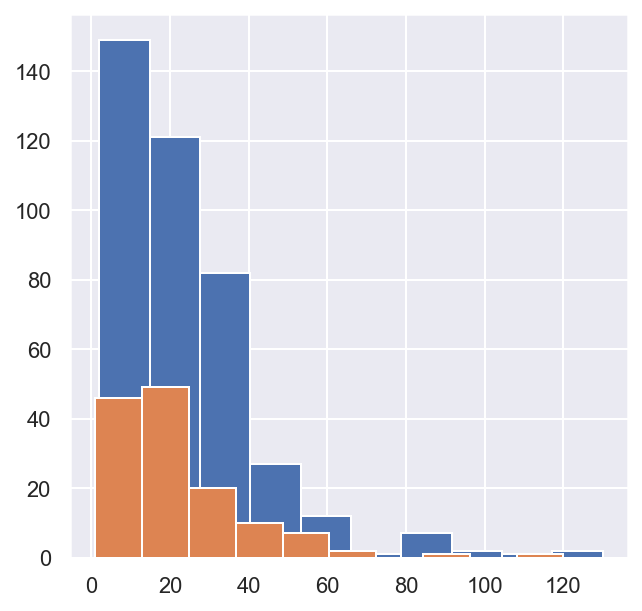

In [39]:
Bev_df.Quantity.hist(figsize = (5,5)), Prod_df.Quantity.hist(figsize = (5,5));


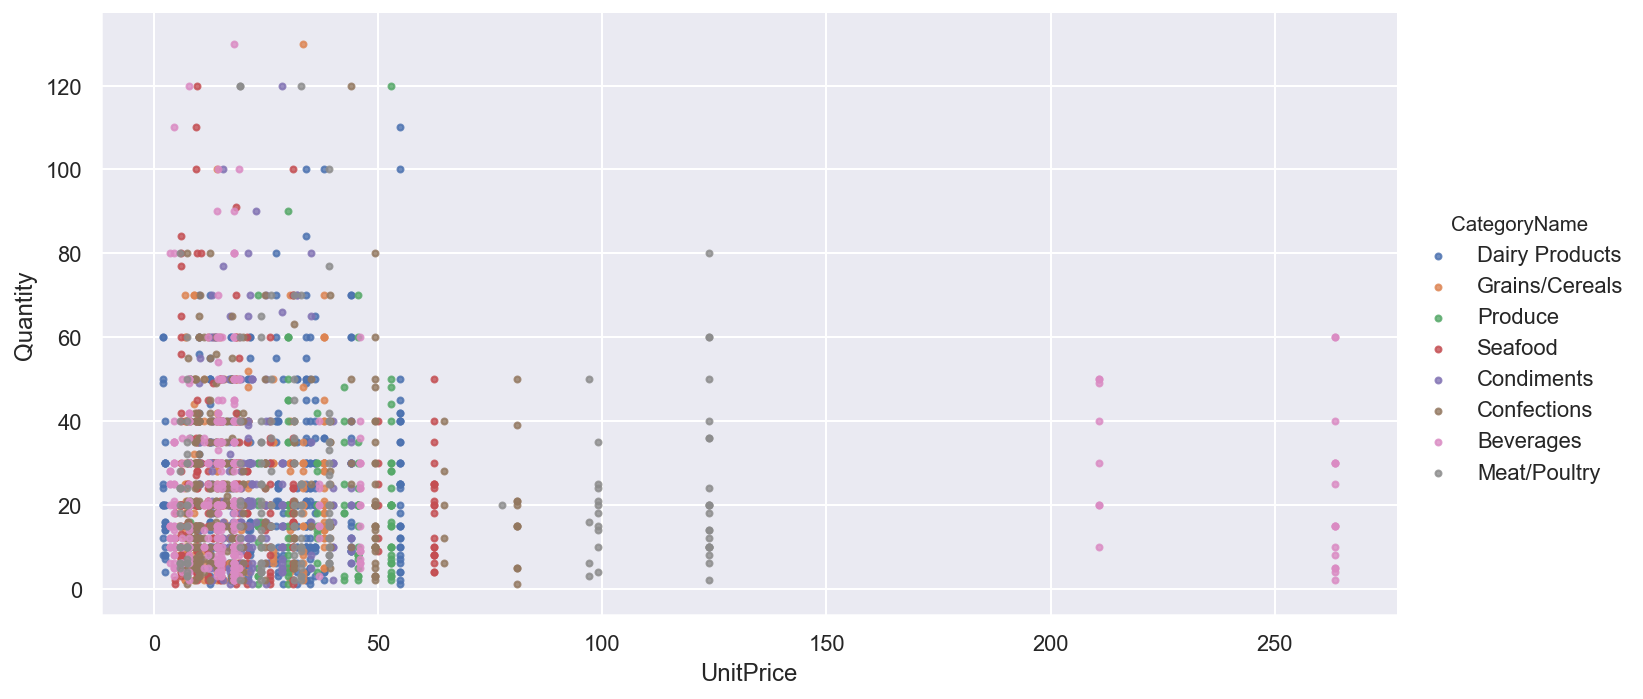

In [40]:
sns.set(rc={'figure.figsize':(15,8)})
sns.lmplot( x="UnitPrice", y="Quantity", data=Cat_df, fit_reg=False, hue='CategoryName', legend=True, aspect= 2, markers =".")
# plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)
plt.show();

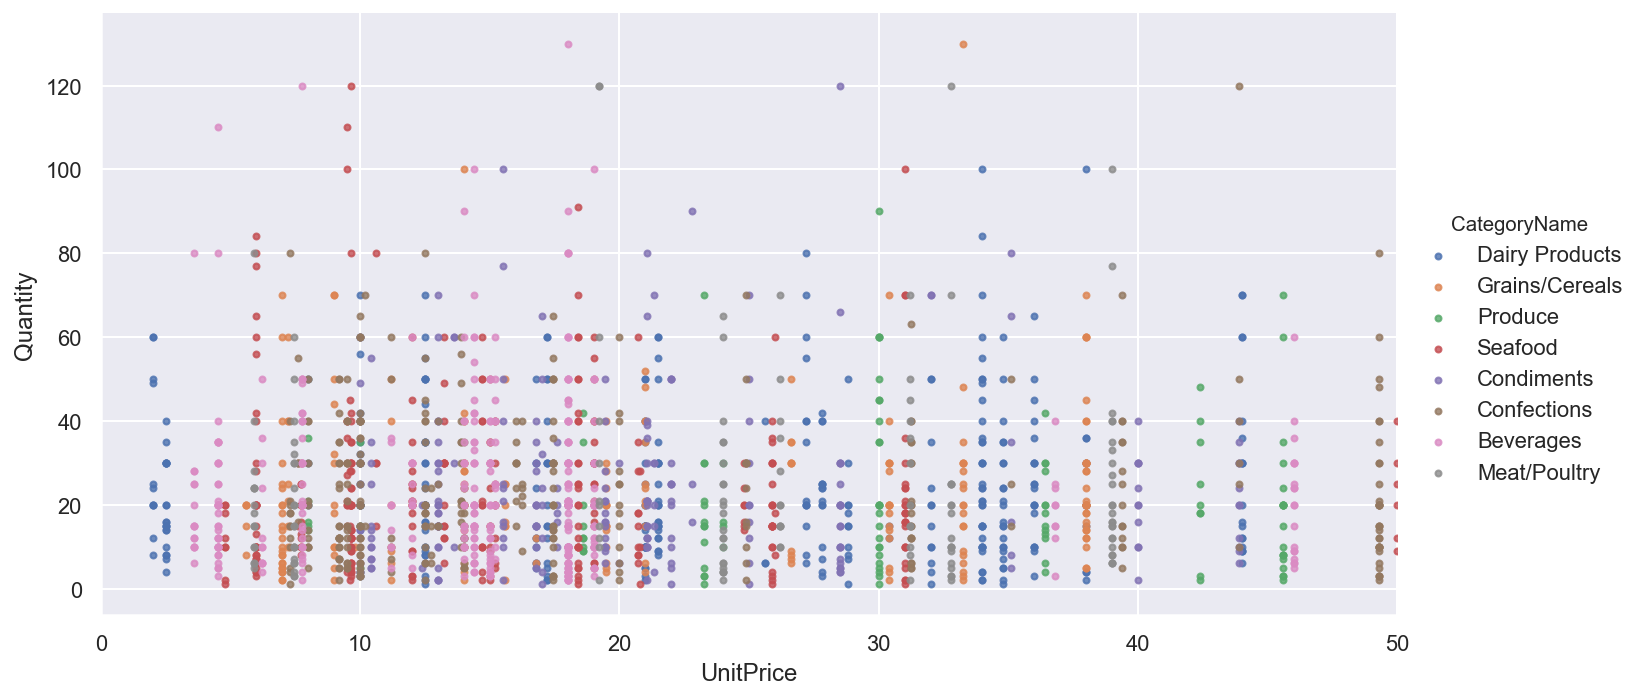

In [41]:
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.lmplot( x="UnitPrice", y="Quantity", data=Cat_df, fit_reg=False, hue='CategoryName', legend=True, aspect= 2, markers =".")
ax.set(xlim=(0,50))
# plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)
plt.show();


In [42]:
Cat_df.loc[Cat_df['UnitPrice'] > 100]

,OrderId,ProductId,UnitPrice,Quantity,Discount,ProductName,CategoryId,CategoryName,ListRev,GrossRev,DiscVal,Disc_0_1
218,10329,38,210.80,20,0.05,Côte de Blaye,1,Beverages,4216.00,4005.200,210.800,1
274,10351,38,210.80,20,0.05,Côte de Blaye,1,Beverages,4216.00,4005.200,210.800,1
281,10353,38,210.80,50,0.20,Côte de Blaye,1,Beverages,10540.00,8432.000,2108.000,1
300,10360,38,210.80,10,0.00,Côte de Blaye,1,Beverages,2108.00,2108.000,0.000,0
331,10372,38,210.80,40,0.25,Côte de Blaye,1,Beverages,8432.00,6324.000,2108.000,1
449,10417,38,210.80,50,0.00,Côte de Blaye,1,Beverages,10540.00,10540.000,0.000,0
471,10424,38,210.80,49,0.20,Côte de Blaye,1,Beverages,10329.20,8263.360,2065.840,1
613,10479,38,210.80,30,0.00,Côte de Blaye,1,Beverages,6324.00,6324.000,0.000,0
684,10510,29,123.79,36,0.00,Thüringer Rostbratwurst,6,Meat/Poultry,4456.44,4456.440,0.000,0
713,10518,38,263.50,15,0.00,Côte de Blaye,1,Beverages,3952.50,3952.500,0.000,0


In [43]:
Cat_df['UnitPrice'].describe()

count    2155.000000
mean       26.218520
std        29.827418
min         2.000000
25%        12.000000
50%        18.400000
75%        32.000000
max       263.500000
Name: UnitPrice, dtype: float64

# Hypothesis #3: Employees

## $H_{0}$ Null Hypothesis
**There is no difference in order quantity between sales representatives of the UK and USA offices.**

## $H_{1}$ Alternative Hypothesis
**There is a difference in order quantity between sales representatives of the UK and USA offices**

Get data for Employees

In [44]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount,
                LastName, Title, City, Country, e.Id,
                od.UnitPrice * od.Quantity AS 'ListRev',
                od.UnitPrice * (1 - od.Discount) * od.Quantity AS 'GrossRev',
                od.Discount * od.UnitPrice * od.Quantity AS 'DiscVal',
                    CASE 
                    WHEN od.Discount == 0 THEN 0
                    ELSE 1 
                    END AS 'Disc_0_1'
                FROM [OrderDetail] od
                JOIN [Order] o
                ON od.OrderId = o.Id
                JOIN Employee e
                ON e.Id = o.EmployeeId""");
                      
Emp_df = pd.DataFrame(cur.fetchall())
Emp_df.columns = [i[0] for i in cur.description]
print(len(Emp_df))
Emp_df.head(5)

2155


,OrderId,ProductId,UnitPrice,Quantity,Discount,LastName,Title,City,Country,Id,ListRev,GrossRev,DiscVal,Disc_0_1
0,10248,11,14.0,12,0.0,Buchanan,Sales Manager,London,UK,5,168.0,168.0,0.0,0
1,10248,42,9.8,10,0.0,Buchanan,Sales Manager,London,UK,5,98.0,98.0,0.0,0
2,10248,72,34.8,5,0.0,Buchanan,Sales Manager,London,UK,5,174.0,174.0,0.0,0
3,10249,14,18.6,9,0.0,Suyama,Sales Representative,London,UK,6,167.4,167.4,0.0,0
4,10249,51,42.4,40,0.0,Suyama,Sales Representative,London,UK,6,1696.0,1696.0,0.0,0


Summary of Quantity, Gross Revenue, Unit Price and Discount Value by Sales Representative

In [45]:
emp = Emp_df.groupby(Emp_df.LastName).agg({'Quantity': ['count', 'sum', 'mean'], 'GrossRev': 'sum', 'UnitPrice': 'mean', 'DiscVal': 'sum'})
emp

Quantity                      GrossRev  UnitPrice     DiscVal
             count   sum       mean          sum       mean         sum
LastName                                                               
Buchanan       117  3036  25.948718   68792.2825  23.482308   6775.4675
Callahan       260  5913  22.742308  126862.2775  23.997115   6438.7525
Davolio        345  7812  22.643478  192107.6045  25.311420  10036.1055
Dodsworth      107  2670  24.953271   77308.0665  31.590654   5655.9335
Fuller         241  6055  25.124481  166537.7550  28.686349  11211.5050
King           176  4654  26.443182  124568.2350  26.804034  16727.7550
Leverling      321  7852  24.461059  202812.8430  27.253645  10238.4570
Peacock        420  9798  23.328571  232890.8460  26.636405  17296.6040
Suyama         168  3527  20.994048   73913.1295  22.827143   4284.9705

Investigating employee title and location

In [46]:
cur.execute("""SELECT DISTINCT
                Id, FirstName, LastName, Title, City, Country
                FROM Employee e
                """);
                      
Emp_list = pd.DataFrame(cur.fetchall())
Emp_list.columns = [i[0] for i in cur.description]
Emp_list

,Id,FirstName,LastName,Title,City,Country
0,1,Nancy,Davolio,Sales Representative,Seattle,USA
1,2,Andrew,Fuller,"Vice President, Sales",Tacoma,USA
2,3,Janet,Leverling,Sales Representative,Kirkland,USA
3,4,Margaret,Peacock,Sales Representative,Redmond,USA
4,5,Steven,Buchanan,Sales Manager,London,UK
5,6,Michael,Suyama,Sales Representative,London,UK
6,7,Robert,King,Sales Representative,London,UK
7,8,Laura,Callahan,Inside Sales Coordinator,Seattle,USA
8,9,Anne,Dodsworth,Sales Representative,London,UK


Removing manager, VP and co-ordinator so that we can compare like with like.  Drop Fuller, Buchanan, Callahan

In [47]:
Emp_df2 = Emp_df.drop(Emp_df[(Emp_df['Id'] == 2) | (Emp_df['Id'] == 5) | (Emp_df['Id'] == 8)].index).sort_values('Country')
Emp_df2.shape

(1537, 14)

Total Gross Revenue by Sales representative 

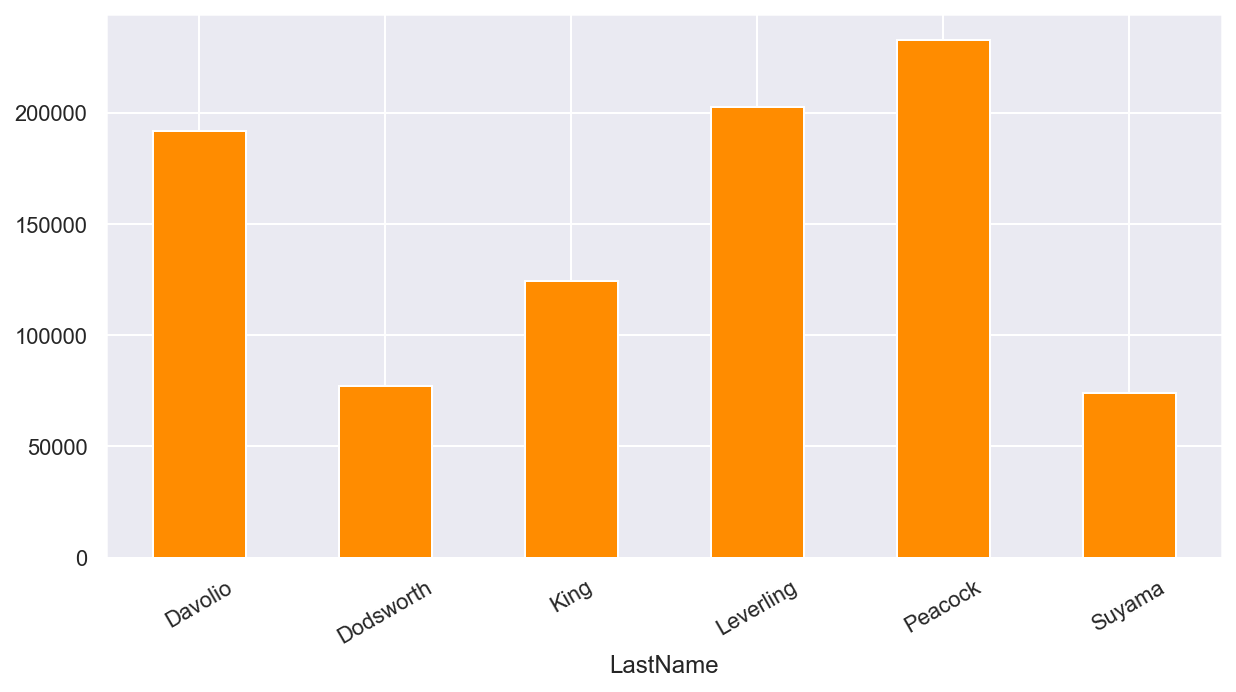

In [48]:
plt.figure(figsize=(10,5))
sum = Emp_df2.groupby('LastName')['GrossRev'].sum()
sum.plot.bar(x='LastName', y='GrossRev', color='darkorange')
plt.xticks(rotation=30)
plt.show();

Mean Quantity by Sales Representative by Country Office

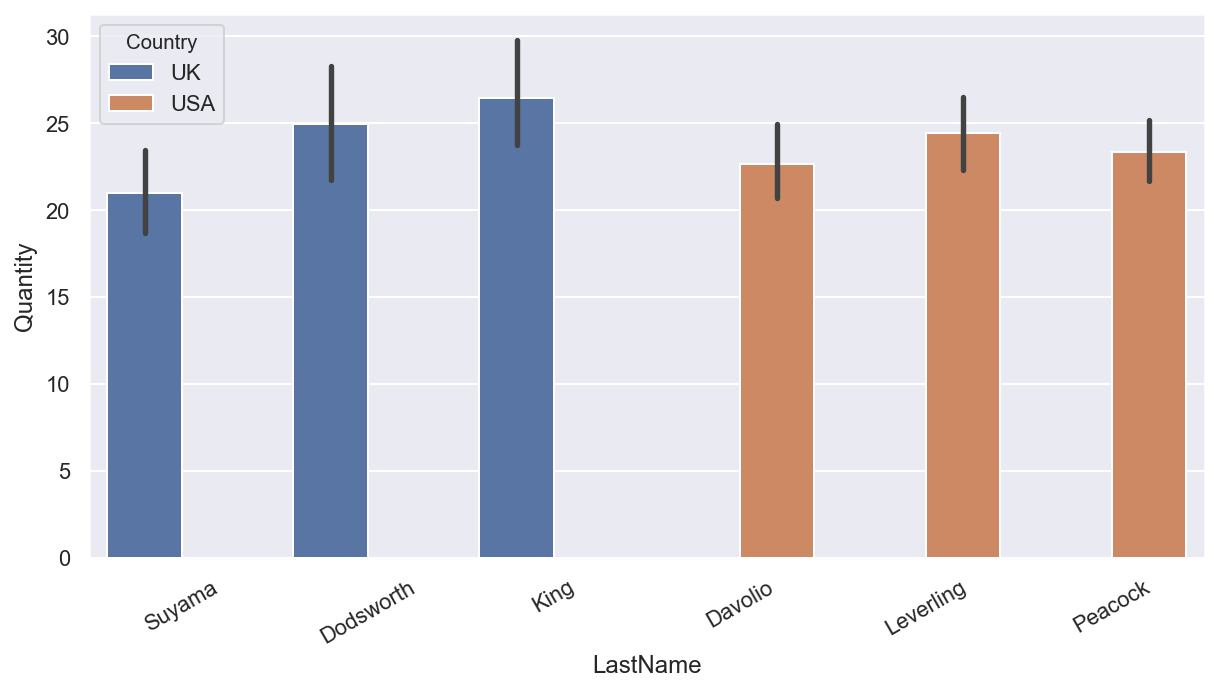

In [49]:
plt.figure(figsize=(10,5))
sns.barplot(x='LastName', y='Quantity', data=Emp_df2, hue='Country')
plt.xticks(rotation=30)
plt.show();

Mean Gross Revenue by Sales Representative by Country Office

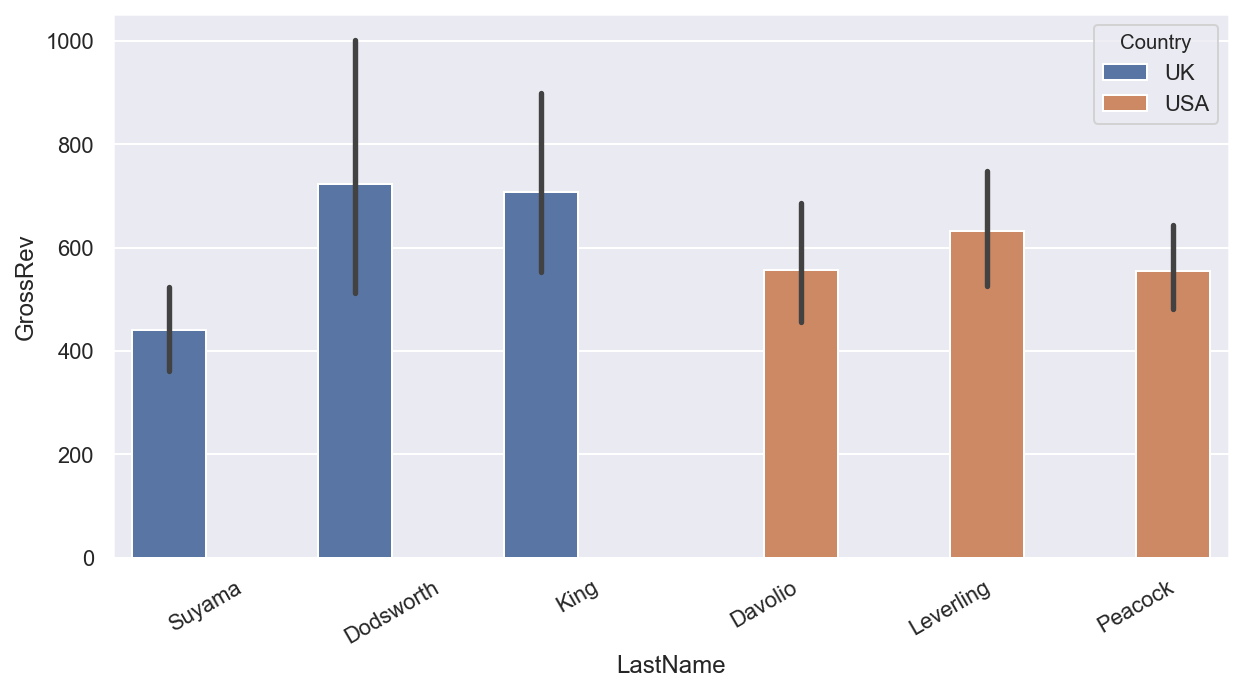

In [50]:
plt.figure(figsize=(10,5))
sns.barplot(x='LastName', y='GrossRev', data=Emp_df2, hue='Country')
plt.xticks(rotation=30)
plt.show();

Mean Discount Value by Sales Representative by Country Office

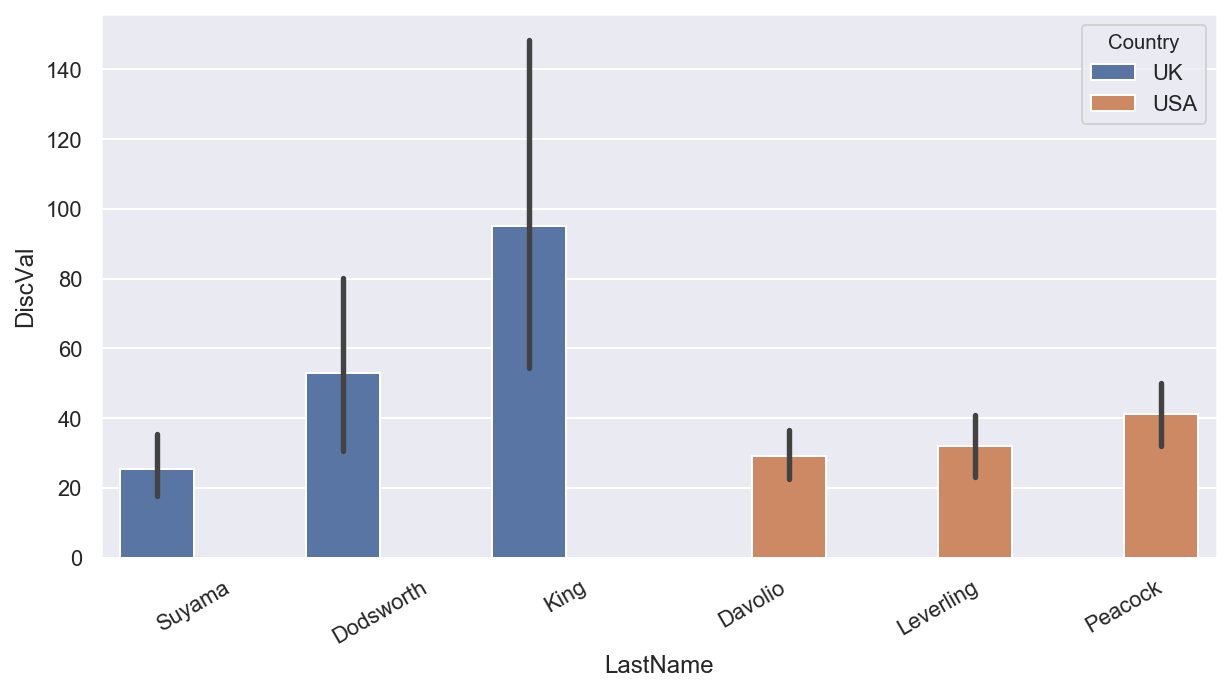

In [51]:
plt.figure(figsize=(10,5))
sns.barplot(x='LastName', y='DiscVal', data=Emp_df2, hue='Country')
plt.xticks(rotation=30)
plt.show();

In [52]:
UK_sales = Emp_df2[Emp_df2['Country']=='UK']
USA_sales = Emp_df2[Emp_df2['Country']=='USA']
# naming the discount / non discount series for simplicty
UK_qty = UK_sales['Quantity']
USA_qty = USA_sales['Quantity']

## Experiment, Testing and Interpret

In the experiment section we will test against our **$H_{0}$ Null Hypothesis** that the sales office has no effect on sales order quantity.

We will perform four test in the experiment section. We are performing a two-tail test - as we are interested in whether order quantity changes between sales offices.

### Welch's t-test

In [53]:
Welch_ttest = stat.ttest_ind(USA_qty, UK_qty, equal_var=False)
print(Welch_ttest)

Ttest_indResult(statistic=-0.5800870779316031, pvalue=0.562013429582247)


#### Interpretation
We get a p-value of 0.5620, this is greater than our $\alpha = 0.05$

Since $p < \alpha$ there is insufficient evidence to reject the Null Hypothesis that there is a difference in order quantity between the UK and USA

### Cohen's d

In [54]:
# Cohen's d formula

def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled variance
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [55]:
Cohen_d(USA_qty, UK_qty)

-0.03270498241893802

#### Interpretation

Cohen provided some general “rule of thumb” guidelines (which should be used cautiously):

Small effect = 0.2
Medium Effect = 0.5
Large Effect = 0.8

Based on these guidelines we can say that sales offices have a statistically insignificant effect on order quantity

### ANOVA

In [56]:
f1 = 'LastName'
f2 = 'Quantity'

In [57]:
formula = '{} ~ C({})'.format(f2, f1)
lm = ols(formula, Emp_df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F    PR(>F)
C(LastName)    3343.128965     5.0  1.902227  0.091011
Residual     538140.760430  1531.0       NaN       NaN


#### Interpretation
With ANOVA we are testing whether there is a significant difference between sales representatives.
The model gives us a p-value of 0.09, which is greater than our $\alpha = 0.05$. There is insufficent evidence to reject the Null Hypothesis that there is no difference between groups of sales representatives.

### Tukey test

In [58]:
mc = MultiComparison(Emp_df2.Quantity, Emp_df2.LastName)
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
 Davolio  Dodsworth  2.3098  -3.6096  8.2292 False 
 Davolio     King    3.7997  -1.1555  8.7549 False 
 Davolio  Leverling  1.8176  -2.3308  5.966  False 
 Davolio   Peacock   0.6851  -3.2018  4.572  False 
 Davolio    Suyama  -1.6494  -6.6821  3.3833 False 
Dodsworth    King    1.4899  -5.0678  8.0476 False 
Dodsworth Leverling -0.4922  -6.4637  5.4793 False 
Dodsworth  Peacock  -1.6247  -7.4176  4.1682 False 
Dodsworth   Suyama  -3.9592  -10.5757 2.6573 False 
   King   Leverling -1.9821  -6.9995  3.0352 False 
   King    Peacock  -3.1146   -7.918  1.6888 False 
   King     Suyama  -5.4491  -11.2191 0.3209 False 
Leverling  Peacock  -1.1325  -5.0984  2.8334 False 
Leverling   Suyama   -3.467   -8.561  1.6269 False 
 Peacock    Suyama  -2.3345  -7.2179  2.5488 False 
---------------------------------------------------
['Davolio' '

#### Interpretation
As expected from ANOVA, we cannot reject the Null Hypothesis. There is no significant difference in order quantity between the different sales representatives.

## Conclusion

* There is insufficent evidence to reject the Null Hypothesis. There is no statistically significant difference in the mean order quantity between sales representatives and sales offices.

# Hypothesis #4: Regions

## $H_{0}$ Null Hypothesis
**There is no difference in sales order gross revenue by region or continent.**

## $H_{1}$ Alternative Hypothesis
**There is a difference in sales order gross revenue by region or continent**

Get data for regions

In [59]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount,
                City, Country, Region,
                od.UnitPrice * od.Quantity AS 'ListRev',
                od.UnitPrice * (1 - od.Discount) * od.Quantity AS 'GrossRev',
                od.Discount * od.UnitPrice * od.Quantity AS 'DiscVal',
                    CASE 
                    WHEN od.Discount == 0 THEN 0
                    ELSE 1 
                    END AS 'Disc_0_1'
                FROM [OrderDetail] od
                LEFT JOIN [Order] o
                ON od.OrderId = o.Id
                LEFT JOIN Customer c
                ON c.Id = o.CustomerId""");
                      
Cust_Reg_df = pd.DataFrame(cur.fetchall())
Cust_Reg_df.columns = [i[0] for i in cur.description]
print(len(Cust_Reg_df))
Cust_Reg_df.head(5)

2155


,OrderId,ProductId,UnitPrice,Quantity,Discount,City,Country,Region,ListRev,GrossRev,DiscVal,Disc_0_1
0,10248,11,14.0,12,0.0,Reims,France,Western Europe,168.0,168.0,0.0,0
1,10248,42,9.8,10,0.0,Reims,France,Western Europe,98.0,98.0,0.0,0
2,10248,72,34.8,5,0.0,Reims,France,Western Europe,174.0,174.0,0.0,0
3,10249,14,18.6,9,0.0,Münster,Germany,Western Europe,167.4,167.4,0.0,0
4,10249,51,42.4,40,0.0,Münster,Germany,Western Europe,1696.0,1696.0,0.0,0


Check that all tables linked ok, and that there are no missing values

In [61]:
Cust_Reg_df.isna().sum()

OrderId       0
ProductId     0
UnitPrice     0
Quantity      0
Discount      0
City         77
Country      77
Region       77
ListRev       0
GrossRev      0
DiscVal       0
Disc_0_1      0
dtype: int64

Identify where the missing values (na) are coming from

In [62]:
cur.execute("""SELECT DISTINCT CustomerId, c.Id AS Cust_Table_Id, City, Country
                FROM [OrderDetail] od
                LEFT JOIN [Order] o
                ON od.OrderId = o.Id
                LEFT JOIN Customer c
                ON c.Id = o.CustomerId
                WHERE City IS NULL""");
                      
Miss_Reg_df = pd.DataFrame(cur.fetchall())
Miss_Reg_df.columns = [i[0] for i in cur.description]
print(len(Miss_Reg_df))
Miss_Reg_df.head(10)

4


,CustomerId,Cust_Table_Id,City,Country
0,DUMO,None,None,None
1,ANTO,None,None,None
2,QUEE,None,None,None
3,OCEA,None,None,None


Are there any similar values elsewhere in the table?

In [63]:
cur.execute("""SELECT Id, CompanyName
                FROM [Customer] 
                WHERE Id LIKE 'DUMO%' 
                OR Id LIKE 'ANTO%'
                OR Id LIKE 'QUEE%' 
                OR Id LIKE 'OCEA%' """);
df = pd.DataFrame(cur.fetchall())
df

,0,1
0,ANTON,Antonio Moreno Taquería
1,DUMON,Du monde entier
2,OCEAN,Océano Atlántico Ltda.
3,QUEEN,Queen Cozinha


It looks like these CustomerId's are missing the last "n". Replace the Id with the correct one.

In [64]:
cur.execute("""UPDATE [Order] 
                SET CustomerId = 'DUMON'
                WHERE CustomerId = 'DUMO'
                """);

In [65]:
cur.execute("""UPDATE [Order] 
                SET CustomerId = 'ANTON'
                WHERE CustomerId = 'ANTO'
                """);

In [66]:
cur.execute("""UPDATE [Order] 
                SET CustomerId = 'QUEEN'
                WHERE CustomerId = 'QUEE'
                """);

In [67]:
cur.execute("""UPDATE [Order] 
                SET CustomerId = 'OCEAN'
                WHERE CustomerId = 'OCEA'
                """);

Re-run the SQL query, after updating the table

In [68]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount,
                City, Country, Region,
                od.UnitPrice * od.Quantity AS 'ListRev',
                od.UnitPrice * (1 - od.Discount) * od.Quantity AS 'GrossRev',
                od.Discount * od.UnitPrice * od.Quantity AS 'DiscVal',
                    CASE 
                    WHEN od.Discount == 0 THEN 0
                    ELSE 1 
                    END AS 'Disc_0_1'
                FROM [OrderDetail] od
                LEFT JOIN [Order] o
                ON od.OrderId = o.Id
                LEFT JOIN Customer c
                ON c.Id = o.CustomerId""");
                      
Cust_Reg_df = pd.DataFrame(cur.fetchall())
Cust_Reg_df.columns = [i[0] for i in cur.description]
print(len(Cust_Reg_df))
Cust_Reg_df.head()

2155


,OrderId,ProductId,UnitPrice,Quantity,Discount,City,Country,Region,ListRev,GrossRev,DiscVal,Disc_0_1
0,10248,11,14.0,12,0.0,Reims,France,Western Europe,168.0,168.0,0.0,0
1,10248,42,9.8,10,0.0,Reims,France,Western Europe,98.0,98.0,0.0,0
2,10248,72,34.8,5,0.0,Reims,France,Western Europe,174.0,174.0,0.0,0
3,10249,14,18.6,9,0.0,Münster,Germany,Western Europe,167.4,167.4,0.0,0
4,10249,51,42.4,40,0.0,Münster,Germany,Western Europe,1696.0,1696.0,0.0,0


View a table of customer count by country and region

In [69]:
cur.execute("""SELECT COUNT(CompanyName), Country, Region 
                FROM [Customer] 
                GROUP BY Country 
                ORDER By Region""");
df = pd.DataFrame(cur.fetchall())
df

,0,1,2
0,1,Ireland,British Isles
1,7,UK,British Isles
2,5,Mexico,Central America
3,1,Poland,Eastern Europe
4,3,Canada,North America
5,13,USA,North America
6,2,Denmark,Northern Europe
7,2,Sweden,Northern Europe
8,2,Finland,Scandinavia
9,1,Norway,Scandinavia


Same table of customer count at region level only

In [70]:
cur.execute("""SELECT Region, COUNT(CompanyName) AS 'Num_Cust'
                FROM [Customer] 
                GROUP BY Region 
                ORDER By Region""");
count_df = pd.DataFrame(cur.fetchall())
count_df.columns = [i[0] for i in cur.description]
count_df

,Region,Num_Cust
0,British Isles,8
1,Central America,5
2,Eastern Europe,1
3,North America,16
4,Northern Europe,4
5,Scandinavia,3
6,South America,16
7,Southern Europe,10
8,Western Europe,28


Plot the number of customers by region. Western Europe has the most

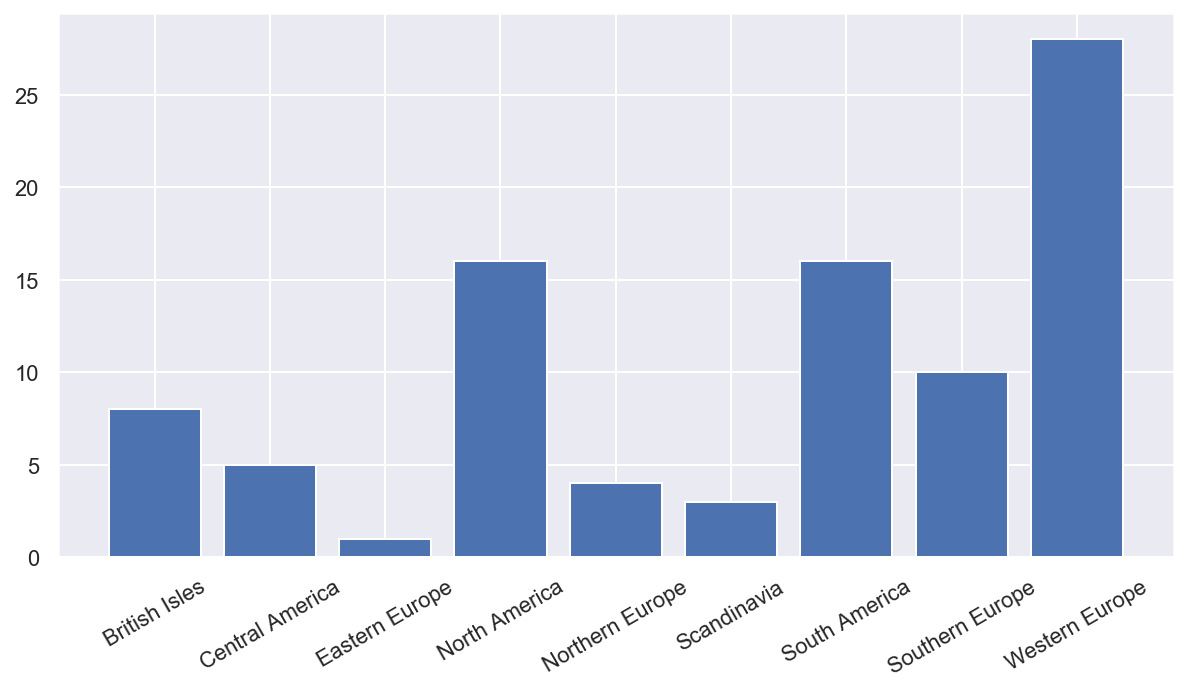

In [71]:
plt.figure(figsize=(10,5))
plt.bar(count_df.Region, count_df.Num_Cust)
plt.xticks(rotation=30)
plt.show();

Adding continent column to the dataframe

In [72]:
Cust_Reg_df['Continent'] = np.where(Cust_Reg_df['Region'].str.contains('America'), 'America', 'Europe')

In [73]:
Cust_Reg_df = Cust_Reg_df.sort_values(['Continent','Region', 'Country'])


In [74]:
cntry_sum = Cust_Reg_df.groupby(['Country']).sum()
cntry_sum

,OrderId,ProductId,UnitPrice,Quantity,Discount,ListRev,GrossRev,DiscVal,Disc_0_1
Country,,,,,,,,,
Argentina,367397,1360,1080.80,339,0.00,8119.10,8119.1000,0.0000,0
Austria,1332339,4832,3469.95,5167,8.60,139496.63,128003.8385,11492.7915,58
Belgium,601255,2442,1341.98,1392,2.15,35134.98,33824.8550,1310.1250,14
Brazil,2162294,8053,5324.64,4247,13.50,114968.48,106925.7765,8042.7035,95
Canada,797169,2975,1907.50,1984,4.80,55334.10,50196.2900,5137.8100,31
Denmark,488463,2172,1212.24,1170,3.10,34782.25,32661.0225,2121.2275,19
Finland,573891,2028,1293.79,885,2.00,19778.45,18810.0525,968.3975,15
France,1956947,7525,4839.46,3254,10.15,85498.76,81358.3225,4140.4375,77
Germany,3487000,13409,8544.84,9213,20.70,244640.63,230284.6335,14355.9965,150


Adding latitude and longitude to the country dataframe, so that countries can be plotted

In [75]:
lat = [-38.4161, 
47.5162, 
50.5039, 
-14.235, 
56.1304, 
56.2639, 
61.9241, 
46.2276, 
51.1657, 
53.1424, 
41.8719, 
23.6345, 
60.472, 
51.9194, 
39.3999, 
40.4637, 
60.1282, 
46.8182, 
55.3781, 
37.0902, 
6.4238 
]

In [76]:
cntry_sum['Latitude'] = lat

In [77]:
long = [-63.6167, 
14.5501, 
4.4699, 
-51.9253, 
-106.3468, 
9.5018, 
25.7482, 
2.2137, 
10.4515, 
-7.6921, 
12.5674, 
-102.5528, 
8.4689, 
19.1451, 
-8.2245, 
-3.7492, 
18.6435, 
8.2275, 
-3.436, 
-95.7129, 
-66.5897 ]


In [78]:
cntry_sum['Longitude'] = long

In [79]:
cntry_sum

,OrderId,ProductId,UnitPrice,Quantity,Discount,ListRev,GrossRev,DiscVal,Disc_0_1,Latitude,Longitude
Country,,,,,,,,,,,
Argentina,367397,1360,1080.80,339,0.00,8119.10,8119.1000,0.0000,0,-38.4161,-63.6167
Austria,1332339,4832,3469.95,5167,8.60,139496.63,128003.8385,11492.7915,58,47.5162,14.5501
Belgium,601255,2442,1341.98,1392,2.15,35134.98,33824.8550,1310.1250,14,50.5039,4.4699
Brazil,2162294,8053,5324.64,4247,13.50,114968.48,106925.7765,8042.7035,95,-14.2350,-51.9253
Canada,797169,2975,1907.50,1984,4.80,55334.10,50196.2900,5137.8100,31,56.1304,-106.3468
Denmark,488463,2172,1212.24,1170,3.10,34782.25,32661.0225,2121.2275,19,56.2639,9.5018
Finland,573891,2028,1293.79,885,2.00,19778.45,18810.0525,968.3975,15,61.9241,25.7482
France,1956947,7525,4839.46,3254,10.15,85498.76,81358.3225,4140.4375,77,46.2276,2.2137
Germany,3487000,13409,8544.84,9213,20.70,244640.63,230284.6335,14355.9965,150,51.1657,10.4515


Plotting country by revenue

In [97]:
import folium

In [98]:
# Make a data frame with dots to show on the map
data = cntry_sum
 
# Make an empty map
m = folium.Map(location=[30, -30], zoom_start=3)
 
# Add circle for each country by revenue on the map
for i in range(0,len(data)):
    folium.CircleMarker([data.iloc[i]['Latitude'], data.iloc[i]['Longitude']],
                radius=data.iloc[i]['GrossRev']/10000,
                color='darkorange',
                fill=True,
                fill_color='darkorange'
                ).add_to(m)

m.save('mymap.html')
m

Summary by Continent / Region / Country

In [82]:
cntry = Cust_Reg_df.groupby(['Continent','Region', 'Country']).agg({'Quantity': ['count', 'sum', 'mean'], 'GrossRev': 'sum', 'UnitPrice': 'mean', 'DiscVal': 'sum'})
cntry

Quantity                      GrossRev  \
                                         count   sum       mean          sum   
Continent Region          Country                                              
America   Central America Mexico            72  1025  14.236111   23582.0775   
          North America   Canada            75  1984  26.453333   50196.2900   
                          USA              352  9330  26.505682  245584.6105   
          South America   Argentina         34   339   9.970588    8119.1000   
                          Brazil           203  4247  20.921182  106925.7765   
                          Venezuela        118  2936  24.881356   56810.6290   
Europe    British Isles   Ireland           55  1684  30.618182   49979.9050   
                          UK               135  2742  20.311111   58971.3100   
          Eastern Europe  Poland            16   205  12.812500    3531.9500   
          Northern Europe Denmark           46  1170  25.434783   32661.0225   
                          Sweden            97  2235  23.041237   54495.1400   
          Scandinavia     Finland           54   885  16.388889   18810.0525   
                          Norway            16   161  10.062500    5735.1500   
          Southern Europe Italy             53   822  15.509434   15770.1550   
                          Portugal          30   533  17.766667   11472.3625   
                          Spain             54   718  13.296296   17983.2000   
          Western Europe  Austria          125  5167  41.336000  128003.8385   
                          Belgium           56  1392  24.857143   33824.8550   
                          France           184  3254  17.684783   81358.3225   
                          Germany          328  9213  28.088415  230284.6335   
                          Switzerland       52  1275  24.519231   31692.6590   

                                       UnitPrice     DiscVal  
                                            mean         sum  
Continent Region          Country                             
America   Central America Mexico       25.263611    491.3725  
          North America   Canada       25.433333   5137.8100  
                          USA          29.724176  17982.3695  
          South America   Argentina    31.788235      0.0000  
                          Brazil       26.229754   8042.7035  
                          Venezuela    20.634831   4004.2610  
Europe    British Isles   Ireland      31.270182   7337.4850  
                          UK           23.087926   1645.2000  
          Eastern Europe  Poland       20.631250      0.0000  
          Northern Europe Denmark      26.353043   2121.2275  
                          Sweden       25.633918   5028.5600  
          Scandinavia     Finland      23.959074    968.3975  
                          Norway       39.605625      0.0000  
          Southern Europe Italy        20.982075    934.9950  
                          Portugal     24.696333    996.2875  
                          Spain        24.023519   1448.6900  
          Western Europe  Austria      27.759600  11492.7915  
                          Belgium      23.963929   1310.1250  
                          France       26.301413   4140.4375  
                          Germany      26.051341  14355.9965  
                          Switzerland  25.609423   1226.8410

Stacked bar chart showing Discount Amount relative to Gross Revenue - both add up to List Price Revenue.

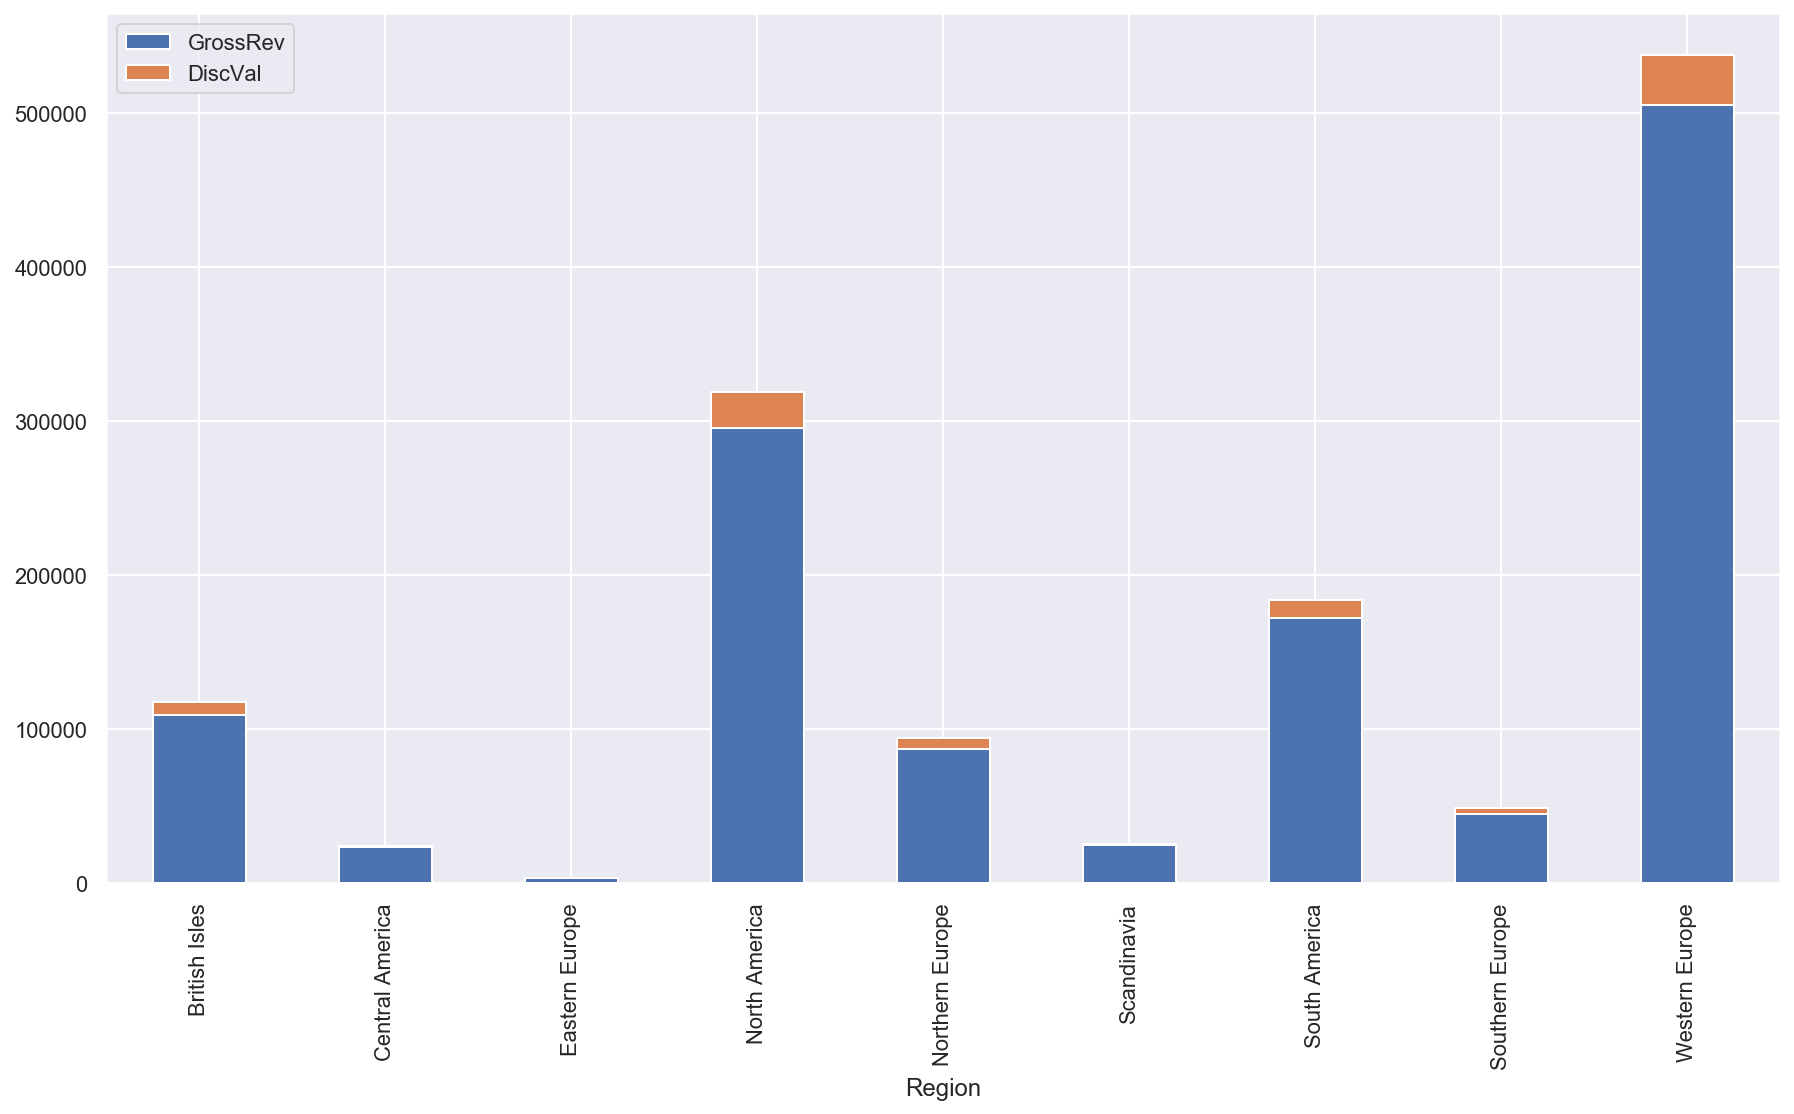

In [83]:
df1=Cust_Reg_df.groupby(['Region'])['GrossRev','DiscVal'].sum()
df1.plot(kind='bar',stacked=True,legend=True);


Stacked bar chart showing mean Discount Amount relative to Gross Revenue - both add up to List Price Revenue. Mean is far more uniform than total aggregation

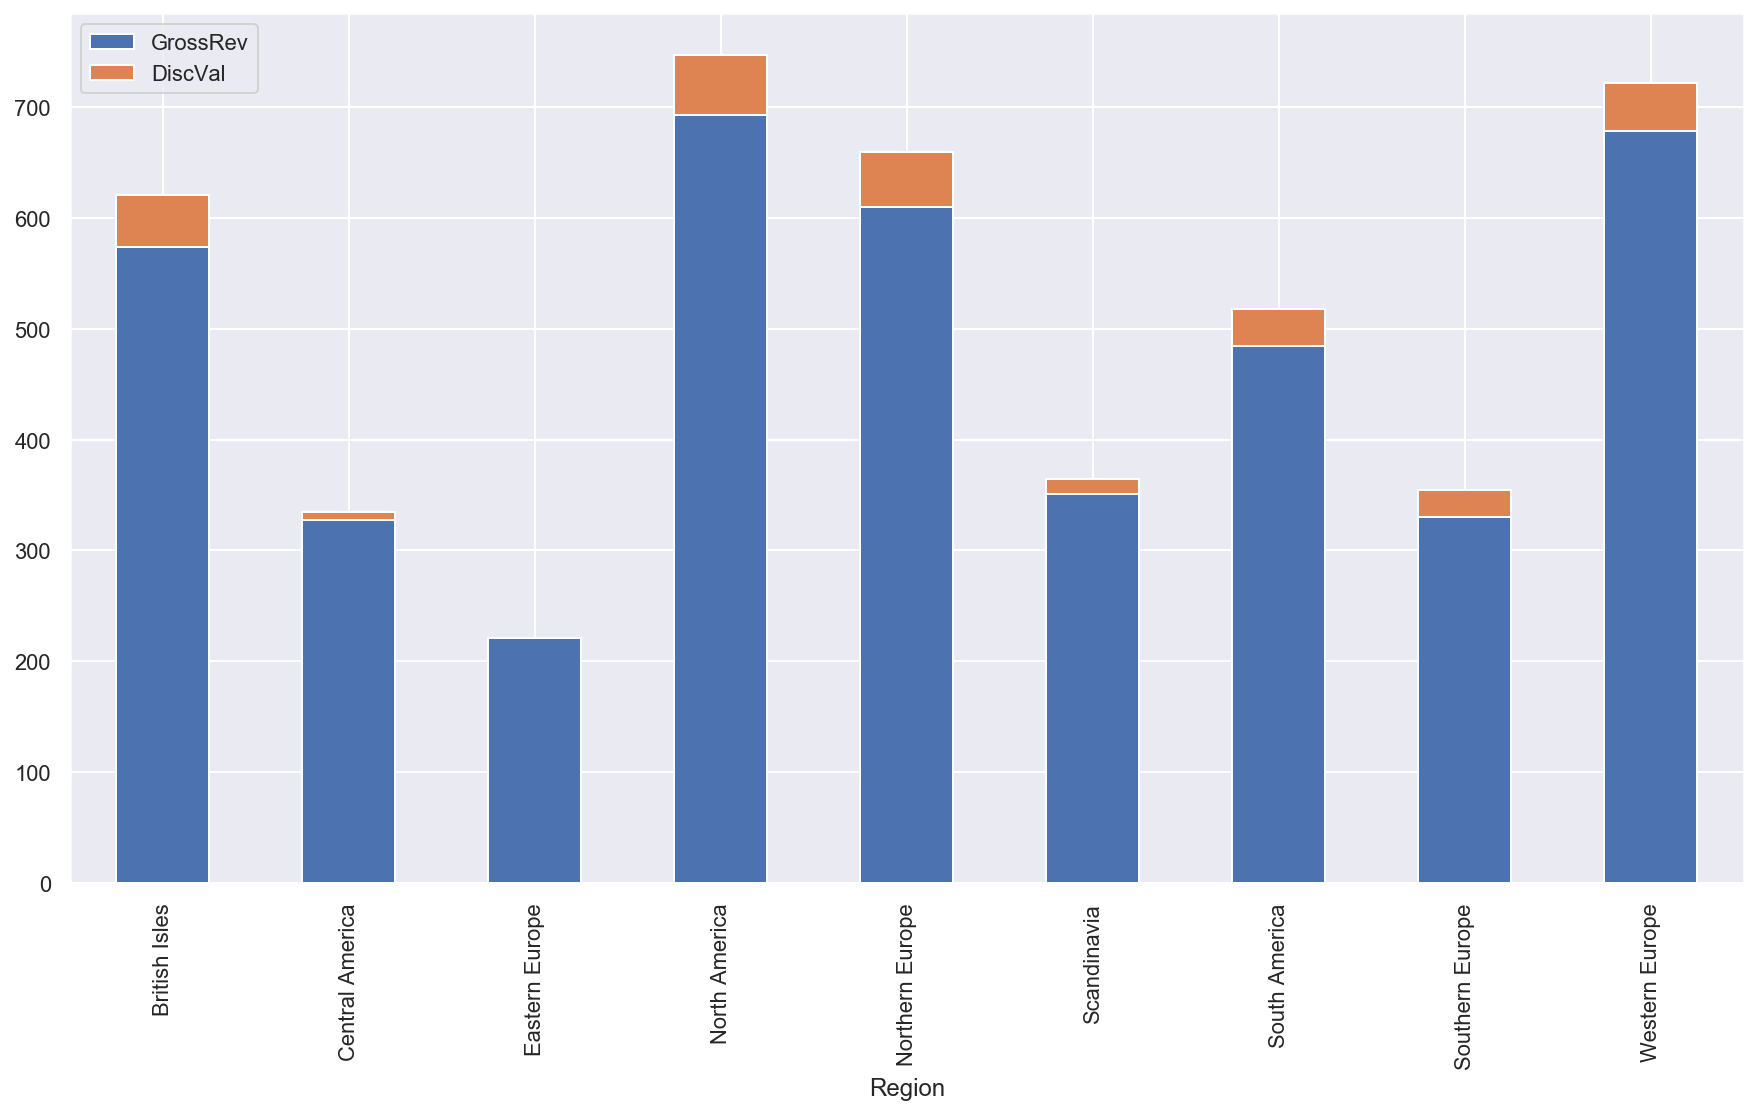

In [84]:
df2=Cust_Reg_df.groupby(['Region'])['GrossRev','DiscVal'].mean()
df2.plot(kind='bar',stacked=True,legend=True);


Summary at the continent level

In [85]:
reg = Cust_Reg_df.groupby(['Continent']).agg({'Quantity': ['count', 'sum', 'mean'], 'GrossRev': ['count', 'sum', 'mean'], 'UnitPrice': 'mean', 'DiscVal': 'sum'})
reg

Quantity                   GrossRev                           \
             count    sum       mean    count          sum        mean   
Continent                                                                
America        854  19861  23.256440      854  491218.4835  575.197287   
Europe        1301  31456  24.178324     1301  774574.5560  595.368606   

           UnitPrice     DiscVal  
                mean         sum  
Continent                         
America    26.966909  35658.5165  
Europe     25.727264  53007.0340

In [86]:
America_Reg = Cust_Reg_df[Cust_Reg_df['Continent']=='America']
Europe_Reg = Cust_Reg_df[Cust_Reg_df['Continent']=='Europe']
# naming the discount / non discount series for simplicty
Amer_Rev = America_Reg['GrossRev']
Euro_Rev = Europe_Reg['GrossRev']

## Experiment, Testing and Interpret

In the experiment section we will test against our **$H_{0}$ Null Hypothesis** that Continents and Regions have no effect on sales order gross revenue.

We will perform four test in the experiment section. We are performing a two-tail test - as we are interested in whether order gross revenue changes, either increases or decreases.

### Welch's t-test

In [87]:
Welch_ttest = stat.ttest_ind(Amer_Rev, Euro_Rev, equal_var=False)
print(Welch_ttest)

Ttest_indResult(statistic=-0.4652563286783527, pvalue=0.6418065206075314)


#### Interpretation
We get a p-value of 0.64, this is greater than our $\alpha = 0.05$

Since $p > \alpha$ we fail to reject the Null Hypothesis that there is no difference in mean order gross revenue between American and European customers


### Cohen's d

In [88]:
# Cohen's d formula

def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled variance
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [89]:
Cohen_d(Amer_Rev, Euro_Rev)

-0.0208079139666178

#### Interpretation

Cohen provided some general “rule of thumb” guidelines (which should be used cautiously):

Small effect = 0.2
Medium Effect = 0.5
Large Effect = 0.8

Based on these guidelines we can say that customer continent has a statistically insignificant effect on order quantity

### ANOVA

In [90]:
f1 = 'Region'
f2 = 'GrossRev'

In [91]:
formula = '{} ~ C({})'.format(f2, f1)
lm = ols(formula, Cust_Reg_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq      df         F   PR(>F)
C(Region)  3.476009e+07     8.0  4.688692  0.00001
Residual   1.988698e+09  2146.0       NaN      NaN


#### Interpretation
With ANOVA we are testing whether there is a significant difference between discount groups.
The model gives us a p-value of 0.00001, which is less than our $\alpha = 0.05$. We can reject the Null Hypothesis that there is no difference between regions. We don't know which specific regions are significant, only that in total they are significant.

### Tukey test

In [92]:
mc = MultiComparison(Cust_Reg_df.GrossRev, Cust_Reg_df.Region)
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

          Multiple Comparison of Means - Tukey HSD,FWER=0.05         
     group1          group2      meandiff   lower      upper   reject
---------------------------------------------------------------------
 British Isles  Central America -245.8986 -659.5434   167.7462 False 
 British Isles   Eastern Europe -352.6806 -1130.7472  425.3861 False 
 British Isles   North America   119.2679 -141.3906   379.9263 False 
 British Isles  Northern Europe  36.0562  -294.8442   366.9566 False 
 British Isles    Scandinavia   -222.7817 -640.6898   195.1264 False 
 British Isles   South America   -89.3274 -358.0024   179.3476 False 
 British Isles  Southern Europe -243.3127  -578.322   91.6965  False 
 British Isles   Western Europe  104.6454 -138.2788   347.5697 False 
Central America  Eastern Europe  -106.782 -932.8867   719.3227 False 
Central America  North America   365.1665  -15.6275   745.9604 False 
Central America Northern Europe  281.9548 -149.9668   713.8764 False 
Central America   Sc

#### Interpretation
Most regions do not produce a significant difference.  However, there is a statistically significant difference in mean order gross revenue between Nth America and Sth Europe, West Europe and Sth America, and West Europe and Sth Europe.

## Conclusion

* There is insufficent evidence to reject the Null Hypothesis at the Continent level.
* However there is some significant difference in mean order gross revenue at the Region level - between Nth America and Sth Europe, West Europe and Sth America, and West Europe and Sth Europe.
* It would be worth further investigating these Regions at a Country level.

# Conclusions

### Discounts
* There is sufficient evidence to reject the Null Hypothesis that discounts have no effect. Discounts produce a small statistically significant effect on the mean order quantity.
* In particular discount amounts of 5%, 15%, 20% and 25% have a significant effect compared with no discount. There is no significant effect between discounts - a 5% discount appears to have the same effect as a 25% discount.

### Category
* There is insufficent evidence to reject the Null Hypothesis. There is no statistically significant difference in the mean order quantity between product categories.
* Note: this test is for quantity only. There may be a significant difference in gross revenue order between the product categories.

### Employee
* There is insufficent evidence to reject the Null Hypothesis. There is no statistically significant difference in the mean order quantity between sales representatives and sales offices.

### Customer Region
* There is insufficent evidence to reject the Null Hypothesis at the Continent level.
* However there is some significant difference in mean order gross revenue at the Region level - between Nth America and Sth Europe, West Europe and Sth America, and West Europe and Sth Europe.
* It would be worth further investigating these Regions at a Country level.

# Future Work

Here are some other areas of the data that I would like to investigate further

### Discounts
* Discounts do lead to an increase in mean order quantity. However, the amount of discount doesn't seem to matter. I am interested in drilling into this further. Is there any difference in product types, or customers that lead to this effect?
* 10% discount does not seem to have an effect. How is this level of discount different from the other discounts?
* Is there any relationship between discount and unit price?
* This analysis was performed on each individual line of an order. What happens if we look at the order in total? Is the order large if any item is discounted? Or is there a threshold number/share of items?
* Do we have any corporate discount agreements with our customers? How do these affect how discounts are offered? Volume discounts? Number of orders within a time period?
* What is the margin on product types? If the margin is small on some products, we may wish to exclude them, as we would have to generate a massive quantity increase to re-coup the discount amount.


### Category
* Time series - have products changed over time? What is growing fastest? What is in decline? Which items are seasonal?
* Has competitor activity affected any products?
* Order basket analysis - are there any products that are "destination products" and included with every order? Are there any products that lead to larger total orders if they are included?
* Which products are regional? What opportunities are there to introduce existing products in new markets?

### Employee
* Which employee has the largest orders? Who has the most orders?
* Who has improved the most over time?
* Does the percentage of discount value to total revenue differ?
* What is the effect of overlapping territories?


### Customer Region
* Do we have any additional information on our customers? For example the ERD shows a table with Customer Demographics, but this table is empty.
* How do orders differ by customer type / location?
* Would like to drill into region and investigate by country and city
* What can we learn from Germany and apply to other markets?

# Extra - delete from project

In [93]:
zz

NameError: name 'zz' is not defined

In [ ]:
# how to do in pandas - no longer necessary

In [ ]:
ord_det['ListRev'] = ord_det['UnitPrice'] * ord_det['Quantity']

In [ ]:
ord_det['GrossRev'] = ord_det['UnitPrice'] * ord_det['Quantity'] * (1 - (ord_det['Discount']))

In [ ]:
ord_det['Disc_Val'] = ord_det['ListRev'] - ord_det['GrossRev']

In [ ]:
ord_det['Disc_0_1'] = np.where(ord_det['Discount'] == 0, 0, 1)

In [ ]:
ord_det.head(12)

In [ ]:
# check column names - for personal exploration

In [ ]:
db_filename = 'Northwind_small.sqlite'
newline_indent = '\n   '

db=sqlite3.connect(db_filename)
db.text_factory = str
cur = db.cursor()

result = cur.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
table_names = sorted(list(zip(*result))[0])
print ("\ntables are:"+newline_indent+newline_indent.join(table_names))

for table_name in table_names:
    result = cur.execute("PRAGMA table_info('%s')" % table_name).fetchall()
    column_names = list(zip(*result))[1]
    print (("\ncolumn names for %s:" % table_name)
           +newline_indent
           +(newline_indent.join(column_names)))

db.close()
print ("\nexiting.")

In [ ]:
# Multiple ttests - for my benefit. This is bad practice

In [ ]:
for group in ord_det.groupby(['Disc_Group'])['Quantity']:
    group_name = group[0]
    print(group_name)

In [ ]:
from itertools import combinations

groups = [group[0] for group in ord_det.groupby(['Disc_Group'])['Quantity']]
combos = combinations(groups, 2)
for combo in combos:
    supp1 = combo[0]
    supp2 = combo[1]
    sample1 = ord_det[(ord_det.Disc_Group == supp1)]['Quantity']
    sample2 = ord_det[(ord_det.Disc_Group == supp2)]['Quantity']
    p = stats.ttest_ind(sample1, sample2, equal_var=False)
    print(combo, p)

In [ ]:
# Check loop result
disc_10 = ord_det[ord_det['Disc_Group']==0.10]
Discount_10_Qty = disc_10['Quantity']
stat.ttest_ind(No_Discount_Qty, Discount_10_Qty, equal_var=False)

In [ ]:
# Welch's t statistic - how to calculate manually

import numpy as np
import scipy.stats as stats

def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """

    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. This function returns the degrees of freedom """
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator


def p_value_welch_ttest(a, b, two_sided=False):
    """Calculates the p-value for Welch's t-test given two samples.
    By default, the returned p-value is for a one-sided t-test. 
    Set the two-sided parameter to True if you wish to perform a two-sided t-test instead.
    """
    t = welch_t(a, b)
    df = welch_df(a, b)
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p

In [ ]:
p_value_welch_ttest(Discount_Qty, No_Discount_Qty)

In [ ]:
# Cohen's d simplified formula ()
from statistics import mean, stdev
from math import sqrt

# test conditions
c0 = Discount_Qty
c1 = No_Discount_Qty

cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))

print(cohens_d)

In [ ]:
# How to export as a csvcat_summary
Cust_Reg_df.to_csv (r'C:\Users\andrew\Documents\project_df.csv', index = None, header=True)

In [ ]:
df3=Cust_Reg_df.groupby(['Disc_0_1'])['GrossRev'].sum()
df3

# Follow up question. How to filter get total for orders with at least one line discounted

In [ ]:
# SQL example
region_count = cur.execute("""SELECT COUNT(CompanyName), Region 
                FROM [Customer] 
                GROUP BY Region 
                ORDER By Region"""), cur.fetchall();
region_count

In [ ]:
for i, g in enumerate(Cust_Reg_df.groupby('Disc_0_1')):
    ax = sns.barplot(data=g[1],
                     x="Region",
                     y="GrossRev",
                     hue="Continent"
                     )
ax.legend_.remove() # remove the redundant legends 

In [ ]:
# Make a data frame with dots to show on the map
data = pd.DataFrame({
'lat':[-58, 2, 145, 30.32, -4.03, -73.57, 36.82, -38.5],
'lon':[-34, 49, -38, 59.93, 5.33, 45.52, -1.29, -12.97],
'name':['Buenos Aires', 'Paris', 'melbourne', 'St Petersbourg', 'Abidjan', 'Montreal', 'Nairobi', 'Salvador'],
'value':['10', '12', '15', '16', '8', '15', '21', '3']
})
data
 
# Make an empty map
m = folium.Map(location=[20, 0], zoom_start=2)
 
# I can add marker one by one on the map
for i in range(0,len(data)):
    folium.CircleMarker([data.iloc[i]['lon'], data.iloc[i]['lat']], popup=data.iloc[i]['name'],
                radius=data.iloc[i]['value'],
                color='crimson',
                fill=True,
                fill_color='crimson'
                ).add_to(m)

m.save('mymap.html')
m

In [ ]:
# Super test - employee by region ... doesn't work, many to many joins
# Delete this before draft to Victor

In [ ]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount,
                c.City, c.Country, c.Region r.RegionDescription
                FROM [OrderDetail] od
                LEFT JOIN [Order] o
                ON od.OrderId = o.Id
                LEFT JOIN [Customer] c
                ON c.Id = o.CustomerId
                LEFT JOIN [Employee] e
                ON e.Id = o.EmployeeId
                LEFT JOIN [EmployeeTerritory] et
                ON e.Id = et.EmployeeId
                LEFT JOIN [Territory] t
                ON t.Id = et.TerritoryId
                LEFT JOIN [Region] r
                ON r.Id = t.RegionId""");
                      
Cust_Reg_df = pd.DataFrame(cur.fetchall())
Cust_Reg_df.columns = [i[0] for i in cur.description]
print(len(Cust_Reg_df))
Cust_Reg_df.head(10)

In [ ]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount,
                City, Country, Region
                FROM [OrderDetail] od
                LEFT JOIN [Order] ob
                ON od.OrderId = o.Id
                LEFT JOIN Customer c
                ON c.Id = o.CustomerId""");

In [ ]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount,
                r.RegionDescription
                FROM [OrderDetail] od
                LEFT JOIN [Order] o
                ON od.OrderId = o.Id
                LEFT JOIN [Employee] e
                ON e.Id = o.EmployeeId
                LEFT JOIN [EmployeeTerritory] et
                ON e.Id = et.EmployeeId
                LEFT JOIN [Territory] t
                ON t.Id = et.TerritoryId
                LEFT JOIN [Region] r
                ON r.Id = t.RegionId""");
                      
Cust_Reg_df = pd.DataFrame(cur.fetchall())
Cust_Reg_df.columns = [i[0] for i in cur.description]
print(len(Cust_Reg_df))
Cust_Reg_df.head(10)

In [ ]:
cur.execute("""SELECT * FROM [Employee] """);
                      
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
print(len(df))
print(df.nunique())
df.head()

In [ ]:
cur.execute("""SELECT * FROM [Order] """);
                      
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
print(len(df))
print(df.nunique())
df.head()

In [ ]:
cur.execute("""SELECT OrderId, ProductId, UnitPrice, Quantity, Discount,
                e.LastName, TerritoryId, TerritoryDescription,
                r.RegionDescription
                FROM [OrderDetail] od
                LEFT JOIN [Order] o
                ON od.OrderId = o.Id
                LEFT JOIN [Employee] e
                ON e.Id = o.EmployeeId
                LEFT JOIN [EmployeeTerritory] et
                ON e.Id = et.EmployeeId
                LEFT JOIN [Territory] t
                ON t.Id = et.TerritoryId
                LEFT JOIN [Region] r
                ON r.Id = t.RegionId""");
                      
Cust_Reg_df = pd.DataFrame(cur.fetchall())
Cust_Reg_df.columns = [i[0] for i in cur.description]
print(len(Cust_Reg_df))
Cust_Reg_df.head(10)

In [ ]:
# Notice that each line in the order is repeated multiple times. Employee has mulitple territories - 
#   we can't determine the unique territory based on employee id

In [ ]:
# This works for select, but doesn't update

# cur.execute("""SELECT CustomerId,
#                 REPLACE (
#                 REPLACE (
#                 REPLACE (
#                 REPLACE (CustomerId, 'DUMO', 'DUMON'), 
#                 'ANTO', 'ANTON'),
#                 'QUEE', 'QUEEN'),
#                 'OCEA', 'OCEAN')
#                 FROM [Order] """);